### Description
This is set up to process the unfolding output.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

import pickle


In [2]:

#fitType = 'bin center approximation'
fitType = 'integral within bin'







rcond_val = 0.001

diagonal_constant = 1.0



use_uniform_fit_hist_binning = True

#use_uniform_fit_hist_binning = False


#uniform_fit_hist_nbins = 20
#uniform_fit_hist_xlow = -3.
#uniform_fit_hist_xhigh = 3.

uniform_fit_hist_nbins = 15
uniform_fit_hist_xlow = -3.
uniform_fit_hist_xhigh = 4.



In [3]:

#samples_from_GenerateInput = False


#input_unfolding_dir = 'output-run-nn-study-nd-v0d-ndim1-res-sf-1.50'

#input_unfolding_dir = 'output-run-kde-study-1d-v0b-res-sf-1.50'


samples_from_GenerateInput = True

#input_unfolding_dir = 'output-run-kde-study-1d-read-input-v0a-smearing-0.0000'
#input_unfolding_dir = 'output-run-kde-study-1d-read-input-v0a-smearing-0.1184'
#input_unfolding_dir = 'output-run-kde-study-1d-read-input-v0a-smearing-0.2368'
#input_unfolding_dir = 'output-run-kde-study-1d-read-input-v0a-smearing-0.3553'
#input_unfolding_dir = 'output-run-kde-study-1d-read-input-v0a-smearing-0.5132'
input_unfolding_dir = 'output-run-kde-study-1d-read-input-v0a-smearing-0.7500'

max_fits = 500


In [4]:

if not samples_from_GenerateInput :

    config_file = '%s/config.txt' % (input_unfolding_dir)

    if not exists(config_file) :

        print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
        sys.exit()

    ndim = int(cu.get_par( config_file, "ndim"))
    print("\n\n Number of feature dimensions: %d\n\n" % ndim)
    
else :

    ndim = 1
    
    

    

In [5]:
input_unfolding_dir

'output-run-kde-study-1d-read-input-v0a-smearing-0.7500'

In [6]:
if not samples_from_GenerateInput :

    with open( '%s/config-pars.pkl' % input_unfolding_dir, 'rb') as f :
        mc_mu = pickle.load(f)
        mc_rho = pickle.load(f)
        mc_sig = pickle.load(f)
        true_mu = pickle.load(f)
        true_rho = pickle.load(f)
        true_sig = pickle.load(f)
        resolution = pickle.load(f)
        mc_cov = pickle.load(f)
        true_cov = pickle.load(f)
        
    print('true_mu : %.3f' % true_mu[0])

    print('true_cov[0,0] : %.3f' % true_cov[0,0])
    
else :
    
    sample_input_dir = cu.get_par( '%s/config.txt' % input_unfolding_dir, 'input_dir')
    print('  sample_input_dir = %s' % sample_input_dir )

    true_mu = np.zeros( shape=(ndim))
    true_cov = np.zeros( shape=(ndim,ndim) )
    true_sig = np.zeros( shape=(ndim))

    pv = cu.get_par( '%s/config.txt' % sample_input_dir,'mu_true')
    true_mu[0] = float(pv)

    print('true_mu : %.3f' % true_mu[0])

    pv = cu.get_par( '%s/config.txt' % sample_input_dir,'var_true')
    true_cov[0,0] = float(pv)
    true_sig[0] = np.sqrt(float(pv))

    print('true_cov[0,0] : %.3f' % true_cov[0,0])
        

  sample_input_dir = input-samples/input-samples-smearing-0.7500-v1b
true_mu : 0.200
true_cov[0,0] : 0.810


In [7]:
n_samples = 0


if not samples_from_GenerateInput :

    for fi in range(5000) :

        fname = '%s/bootstrap-weights-%03d.npy' % (input_unfolding_dir, fi)

        if exists(fname) :
            n_samples = n_samples + 1
            
else :
    
    for fi in range(5000) :
    
        fname = '%s/sample-%04d.npz' % (sample_input_dir, fi)
    
        if exists(fname) :
            n_samples = n_samples + 1
        
print("\n\n Found %d samples.\n\n" % n_samples )



 Found 500 samples.




In [8]:
def read_sample( input_dir, sample_index ) :
    
    with np.load( '%s/sample-%04d.npz' % (input_dir, sample_index) ) as f:
        read_true_det_pts = f['data']
        read_mc_pts = f['gen']
        read_mc_det_pts = f['sim']

    ngen_true = len(read_true_det_pts)
    ngen_mc = len(read_mc_pts)

    this_ngen_true = ngen_true

    #-- package these in the same format as what I was using.

    true_det_pts = np.zeros( shape=(ngen_true,1) )
    true_det_pts[:,0] = read_true_det_pts

    mc_pts = np.zeros( shape=(ngen_mc,1) )
    mc_pts[:,0] = read_mc_pts

    mc_det_pts = np.zeros( shape=(ngen_mc,1) )
    mc_det_pts[:,0] = read_mc_det_pts
    
    return_dict = {}
    

    return_dict['true_det_pts'] = true_det_pts
    return_dict['mc_pts'] = mc_pts
    return_dict['mc_det_pts'] = mc_det_pts
    return_dict['ngen_true'] = ngen_true
    return_dict['ngen_mc'] = ngen_mc
    
    return return_dict
    
    

In [9]:
if not samples_from_GenerateInput :

    with open( '%s/mc-and-true-samples.npy' % input_unfolding_dir, 'rb') as f :
        mc_pts = np.load(f)
        mc_det_pts = np.load(f)
        true_pts = np.load(f)
        true_det_pts = np.load(f)
        
    print()
    print('mc_pts     shape :  %s ' % str(mc_pts.shape))
    print('mc_det_pts shape :  %s' % str(mc_det_pts.shape))
    print('true_pts      shape :  %s' % str(true_pts.shape))
    print('true_det_pts  shape :  %s' % str(true_det_pts.shape))
    print()

## Calculate the model parameters from simple average and covariance from weighted events

In [10]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * mc_pts[:,fi1] )
    wx2 = np.sum( weights * mc_pts[:,fi2] )
    wx1x2 = np.sum( weights * mc_pts[:,fi1] * mc_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * mc_pts[:,fi1] * mc_pts[:,fi1] )
        wx2x2 = np.sum( weights * mc_pts[:,fi2] * mc_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [11]:
%%time

all_mean = np.zeros( shape=(ndim,n_samples) )
all_rms = np.zeros( shape=(ndim,n_samples) )
all_cov = np.zeros( shape=(ndim,ndim,n_samples) )
all_rho = np.zeros( shape=(ndim,ndim,n_samples) )

all_weight_min = np.zeros( n_samples )
all_weight_max = np.zeros( n_samples )

all_weight_sum = np.zeros( n_samples )


si = 0

for fi in range(n_samples) :
    
    if samples_from_GenerateInput :
        
        rd = read_sample( sample_input_dir, fi )

        ngen_true = rd['ngen_true']
        ngen_mc = rd['ngen_mc']

        true_det_pts = rd['true_det_pts']
        mc_pts = rd['mc_pts']
        mc_det_pts = rd['mc_det_pts']
        
        if fi < 5 :
            print(' mc_pts for sample %d : %s' % (fi, str(mc_pts)))
    

    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_unfolding_dir, fi)
    
    if exists(fname) :
        
        print('\n----- %s exists' % fname )
        
        with open(fname,'rb') as f :
            
            final_push_weights_scaled = np.load(f)
            
        print( len(final_push_weights_scaled))
        print( final_push_weights_scaled )


        all_weight_min[si] = np.min( final_push_weights_scaled )
        all_weight_max[si] = np.max( final_push_weights_scaled )

        all_weight_sum[si] = np.sum( final_push_weights_scaled )

        for fi1 in range(ndim) :
            for fi2 in range(fi1,ndim) :
                mean_cov = calc_mean_cov( final_push_weights_scaled, fi1, fi2 )
                all_cov[fi1,fi2,si] = mean_cov["cov_x1x2"]
                all_cov[fi2,fi1,si] = mean_cov["cov_x1x2"]
                if ( fi1 == fi2 ) :
                    print( "  %d %d  :  mean = %8.4f, RMS = %8.4f, cov = %8.4f" % 
                          (fi1, fi2, mean_cov["mean_x1"], mean_cov["rms1"], mean_cov["cov_x1x2"]))
                    all_mean[fi1,si] = mean_cov["mean_x1"]
                    all_rms[fi1,si] = mean_cov["rms1"]
                else :
                    print( "  %d %d  :  rho = %8.4f,  cov = %8.4f" %
                          (fi1, fi2, mean_cov["rho12"], mean_cov["cov_x1x2"]) )
                    all_rho[fi1,fi2,si] = mean_cov["rho12"]
                    all_rho[fi2,fi1,si] = mean_cov["rho12"]
                        
        si = si + 1
        
            

 mc_pts for sample 0 : [[-0.41116506]
 [ 0.64835222]
 [-1.50112681]
 ...
 [-0.99829224]
 [-0.61898693]
 [ 1.37044705]]

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-000.npy exists
100000
[0.09511925 0.11798256 0.06524012 ... 0.0801359  0.08986147 0.12491232]
  0 0  :  mean =   0.1807, RMS =   0.9167, cov =   0.8403
 mc_pts for sample 1 : [[-0.41116506]
 [ 0.64835222]
 [-1.50112681]
 ...
 [-0.99829224]
 [-0.61898693]
 [ 1.37044705]]

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-001.npy exists
100000
[0.10095929 0.1170865  0.06063099 ... 0.0826898  0.0952877  0.11875615]
  0 0  :  mean =   0.1739, RMS =   0.9037, cov =   0.8166
 mc_pts for sample 2 : [[-0.41116506]
 [ 0.64835222]
 [-1.50112681]
 ...
 [-0.99829224]
 [-0.61898693]
 [ 1.37044705]]

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-002.npy exists
100000
[0.09290129 0.11836267 0.0637324  ... 0.07760789 0.08829237 0.12364354]
  0 0


----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-043.npy exists
100000
[0.09714524 0.11675366 0.05831823 ... 0.07890151 0.09160134 0.12413138]
  0 0  :  mean =   0.2008, RMS =   0.9059, cov =   0.8207

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-044.npy exists
100000
[0.09948997 0.11896384 0.05673919 ... 0.07737411 0.092201   0.1197991 ]
  0 0  :  mean =   0.1947, RMS =   0.9121, cov =   0.8319

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-045.npy exists
100000
[0.09540321 0.11731104 0.05453063 ... 0.07304363 0.08806136 0.11774584]
  0 0  :  mean =   0.2059, RMS =   0.9181, cov =   0.8429

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-046.npy exists
100000
[0.09483317 0.11535565 0.06394924 ... 0.07810375 0.08904261 0.11520835]
  0 0  :  mean =   0.1790, RMS =   0.9201, cov =   0.8466

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-

100000
[0.09278315 0.11877638 0.05967755 ... 0.07540739 0.08771527 0.12875157]
  0 0  :  mean =   0.2085, RMS =   0.9164, cov =   0.8397

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-092.npy exists
100000
[0.09493087 0.11726935 0.06329862 ... 0.07823539 0.08959311 0.11858025]
  0 0  :  mean =   0.1844, RMS =   0.9136, cov =   0.8346

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-093.npy exists
100000
[0.09482698 0.12181545 0.05736817 ... 0.0748415  0.08808272 0.1199922 ]
  0 0  :  mean =   0.1999, RMS =   0.9069, cov =   0.8224

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-094.npy exists
100000
[0.09492968 0.11959207 0.05383638 ... 0.07350676 0.08770736 0.12154715]
  0 0  :  mean =   0.2228, RMS =   0.9043, cov =   0.8178

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-095.npy exists
100000
[0.09918945 0.1150862  0.05770327 ... 0.07862689 0.09308196 0.127


----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-139.npy exists
100000
[0.09605936 0.11966928 0.05835316 ... 0.07545029 0.08990381 0.12117209]
  0 0  :  mean =   0.2001, RMS =   0.9099, cov =   0.8280

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-140.npy exists
100000
[0.09299136 0.11916787 0.05784765 ... 0.07515035 0.0875728  0.12002033]
  0 0  :  mean =   0.1993, RMS =   0.9155, cov =   0.8381

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-141.npy exists
100000
[0.09844702 0.11894172 0.05800309 ... 0.0766424  0.09115892 0.12214568]
  0 0  :  mean =   0.1993, RMS =   0.9092, cov =   0.8266

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-142.npy exists
100000
[0.09523398 0.11908582 0.05863595 ... 0.07714528 0.08889226 0.12639785]
  0 0  :  mean =   0.2129, RMS =   0.9204, cov =   0.8472

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-


----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-187.npy exists
100000
[0.09856262 0.11971855 0.06206812 ... 0.08050764 0.09256575 0.12164937]
  0 0  :  mean =   0.1828, RMS =   0.9074, cov =   0.8234

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-188.npy exists
100000
[0.09370944 0.12360379 0.05531879 ... 0.07316731 0.08651186 0.12793454]
  0 0  :  mean =   0.2189, RMS =   0.8952, cov =   0.8013

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-189.npy exists
100000
[0.09755293 0.11525711 0.0604942  ... 0.07917534 0.09156465 0.11888865]
  0 0  :  mean =   0.1781, RMS =   0.9179, cov =   0.8426

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-190.npy exists
100000
[0.09497932 0.1204922  0.05730285 ... 0.0758284  0.08948086 0.12293618]
  0 0  :  mean =   0.2078, RMS =   0.9102, cov =   0.8285

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-


----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-236.npy exists
100000
[0.09489059 0.11547848 0.06426899 ... 0.07815334 0.08872183 0.12126571]
  0 0  :  mean =   0.1883, RMS =   0.9305, cov =   0.8659

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-237.npy exists
100000
[0.09388879 0.12183316 0.05867949 ... 0.07279991 0.08624534 0.12460078]
  0 0  :  mean =   0.2103, RMS =   0.9083, cov =   0.8251

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-238.npy exists
100000
[0.09475716 0.11650885 0.06010935 ... 0.07861093 0.09018478 0.12186029]
  0 0  :  mean =   0.2019, RMS =   0.9140, cov =   0.8353

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-239.npy exists
100000
[0.09336489 0.12022131 0.06270457 ... 0.07640977 0.08759491 0.12007711]
  0 0  :  mean =   0.1893, RMS =   0.9166, cov =   0.8401

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-


----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-284.npy exists
100000
[0.094181   0.1205638  0.05895827 ... 0.07573855 0.08765938 0.12684226]
  0 0  :  mean =   0.2003, RMS =   0.9083, cov =   0.8251

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-285.npy exists
100000
[0.09255063 0.11666309 0.05383757 ... 0.07152549 0.08529559 0.12221415]
  0 0  :  mean =   0.2143, RMS =   0.9087, cov =   0.8257

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-286.npy exists
100000
[0.09579846 0.12011211 0.05735531 ... 0.07698369 0.08949778 0.12511148]
  0 0  :  mean =   0.2047, RMS =   0.9154, cov =   0.8379

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-287.npy exists
100000
[0.09371147 0.11659974 0.0637884  ... 0.07783027 0.08797316 0.11897713]
  0 0  :  mean =   0.1880, RMS =   0.9205, cov =   0.8473

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-


----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-334.npy exists
100000
[0.09628922 0.12435225 0.05382227 ... 0.07191575 0.08734085 0.1254913 ]
  0 0  :  mean =   0.2267, RMS =   0.9016, cov =   0.8129

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-335.npy exists
100000
[0.09618463 0.11644017 0.05678449 ... 0.07665076 0.09043109 0.11940743]
  0 0  :  mean =   0.1932, RMS =   0.9149, cov =   0.8371

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-336.npy exists
100000
[0.09399004 0.1186593  0.06114725 ... 0.07850924 0.08844746 0.11933601]
  0 0  :  mean =   0.1792, RMS =   0.9193, cov =   0.8451

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-337.npy exists
100000
[0.09508559 0.12120653 0.05633716 ... 0.07292867 0.08643147 0.12026919]
  0 0  :  mean =   0.1979, RMS =   0.9046, cov =   0.8183

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-


----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-382.npy exists
100000
[0.09560039 0.11646872 0.06206729 ... 0.08192779 0.09168151 0.12467153]
  0 0  :  mean =   0.1921, RMS =   0.9198, cov =   0.8461

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-383.npy exists
100000
[0.09164693 0.11849167 0.06295012 ... 0.07644714 0.0871305  0.12434488]
  0 0  :  mean =   0.2026, RMS =   0.9367, cov =   0.8773

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-384.npy exists
100000
[0.09501746 0.1181765  0.06461101 ... 0.07846911 0.08977506 0.12560175]
  0 0  :  mean =   0.1895, RMS =   0.9181, cov =   0.8429

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-385.npy exists
100000
[0.09776768 0.11950574 0.05749605 ... 0.07833026 0.09169855 0.11962558]
  0 0  :  mean =   0.1982, RMS =   0.9015, cov =   0.8127

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-


----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-432.npy exists
100000
[0.10005765 0.11713343 0.06141768 ... 0.08042973 0.09441082 0.1163147 ]
  0 0  :  mean =   0.1657, RMS =   0.9019, cov =   0.8135

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-433.npy exists
100000
[0.09780393 0.11649104 0.06068082 ... 0.07818443 0.09135701 0.12252763]
  0 0  :  mean =   0.1888, RMS =   0.9256, cov =   0.8568

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-434.npy exists
100000
[0.09272146 0.12004918 0.05748326 ... 0.07374445 0.08624894 0.12431371]
  0 0  :  mean =   0.2135, RMS =   0.9087, cov =   0.8257

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-435.npy exists
100000
[0.09213124 0.12070469 0.05543364 ... 0.07231968 0.08569805 0.1289972 ]
  0 0  :  mean =   0.2246, RMS =   0.9133, cov =   0.8342

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-


----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-482.npy exists
100000
[0.0931725  0.11857787 0.05514544 ... 0.07268851 0.08563621 0.11588843]
  0 0  :  mean =   0.2105, RMS =   0.9044, cov =   0.8180

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-483.npy exists
100000
[0.09530853 0.11773127 0.06154578 ... 0.07813351 0.08965764 0.12651237]
  0 0  :  mean =   0.1931, RMS =   0.9228, cov =   0.8515

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-484.npy exists
100000
[0.09657295 0.11762654 0.058227   ... 0.07710173 0.0905077  0.11659587]
  0 0  :  mean =   0.1876, RMS =   0.9053, cov =   0.8195

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-485.npy exists
100000
[0.098556   0.1163332  0.05884783 ... 0.07860958 0.0926013  0.12172396]
  0 0  :  mean =   0.1976, RMS =   0.9117, cov =   0.8311

----- output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-

<function matplotlib.pyplot.show(close=None, block=None)>

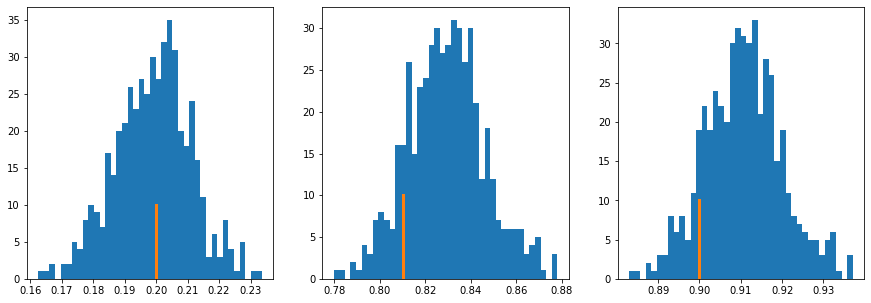

In [12]:
fig,ax = plt.subplots( ndim, 3, figsize=(3*5,ndim*5))

ymax = 10

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    thisax.hist( all_mean[i], bins=40)
    thisax.plot( (true_mu[i], true_mu[i]), (0,ymax), linewidth=3 )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    thisax.hist( all_cov[i][i], bins=40)
    thisax.plot( (true_cov[i][i], true_cov[i][i]), (0,ymax), linewidth=3 )


    
    if ndim > 1 :
        thisax = ax[i][2]
    else :
        thisax = ax[2]    
    thisax.hist( all_rms[i], bins=40)
    thisax.plot( (true_sig[i], true_sig[i]), (0,ymax), linewidth=3 )    
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

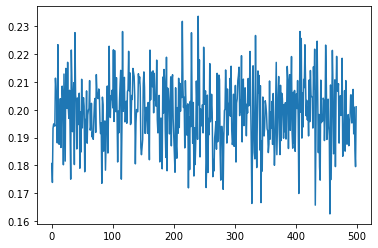

In [13]:
plt.plot(all_mean[0])
plt.show

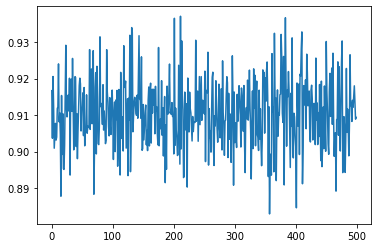

In [14]:
plt.plot(all_rms[0])

<function matplotlib.pyplot.show(close=None, block=None)>

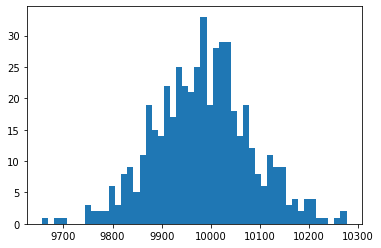

In [15]:
plt.hist( all_weight_sum, bins=50 )
plt.show

In [16]:
print( 'Weight sum RMS: %.1f' % np.sqrt( np.cov(all_weight_sum)))

Weight sum RMS: 98.6


In [17]:
print('\n')

ave_mean = np.zeros( ndim )
rms_mean = np.zeros( ndim )
rms_mean_err = np.zeros( ndim )

ave_cov = np.zeros( shape=(ndim,ndim) )
rms_cov = np.zeros( shape=(ndim,ndim) )
rms_cov_err = np.zeros( shape=(ndim,ndim) )


for fi in range(ndim) :
    
    ave_mean[fi] = np.mean( all_mean[fi] )
    ave_mean2 = np.mean( all_mean[fi]*all_mean[fi])
    rms_mean[fi] = np.sqrt( ave_mean2 - ave_mean[fi]*ave_mean[fi] )
    rms_mean_err[fi] = rms_mean[fi] / np.sqrt(2*n_samples)
    print("  feature %d  :  mean   ave %8.4f  (true %8.4f), rms %8.5f +/- %6.5f" % 
          (fi, ave_mean[fi], true_mu[fi], rms_mean[fi], rms_mean_err[fi] ))
    
print('\n')

for fi in range(ndim) :
    
    ave_rms = np.mean( all_rms[fi] )
    ave_rms2 = np.mean( all_rms[fi]*all_rms[fi])
    rms_rms = np.sqrt( ave_rms2 - ave_rms*ave_rms )
    print("  feature %d  :  RMS    ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_rms, true_sig[fi], rms_rms ))
    
print('\n')

for fi1 in range(0,ndim-1) :
    for fi2 in range(fi1+1, ndim) :
        k = ndim - fi2 - 1
        ave_rho = np.mean( all_rho[fi1,fi2])
        ave_rho2 = np.mean( all_rho[fi1,fi2]*all_rho[fi1,fi2] )
        rms_rho = np.sqrt( ave_rho2 - ave_rho*ave_rho )
        print("  feature %d, %d  :  rho    ave %8.4f  (true %8.4f), rms %8.4f" % ( fi1, fi2, ave_rho, true_rho[fi1][k], rms_rho ))
        
print("\n")

for fi1 in range(0,ndim) :
    for fi2 in range(fi1,ndim) :
        ave_cov[fi1,fi2] = np.mean( all_cov[fi1][fi2] )
        ave_cov2 = np.mean( all_cov[fi1][fi2]*all_cov[fi1][fi2] )
        rms_cov[fi1,fi2] = np.sqrt( ave_cov2 - ave_cov[fi1,fi2]*ave_cov[fi1,fi2] )
        rms_cov_err[fi1,fi2] = rms_cov[fi1,fi2]/np.sqrt(2*n_samples)
        print("  feature %d, %d  :  cov    ave %8.4f  (true %8.4f), rms %8.5f +/- %6.5f" %
              (fi1, fi2, ave_cov[fi1,fi2], true_cov[fi1,fi2], rms_cov[fi1,fi2], rms_cov_err[fi1,fi2] ) )

print("\n")



  feature 0  :  mean   ave   0.1991  (true   0.2000), rms  0.01197 +/- 0.00038


  feature 0  :  RMS    ave   0.9106  (true   0.9000), rms   0.0093




  feature 0, 0  :  cov    ave   0.8293  (true   0.8100), rms  0.01694 +/- 0.00054




In [18]:
with open( '%s/simple-calc-results.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, ave_mean )
    np.save( f, rms_mean )
    np.save( f, ave_cov )
    np.save( f, rms_cov )

In [19]:
with open( '%s/simple-calc-per-sample-results.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, all_mean )
    np.save( f, all_cov )


## Run the unbinned ML fits

In [20]:
import ROOT
import gc

Module libc not found.


Welcome to JupyROOT 6.30/09


In [21]:
ROOT.gSystem.Load('./RooMultiVarGaussian2e_cxx.so')

0

In [22]:
width_factor_mean = 10
width_factor_cov = 10

In [23]:
covdict = {}


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        startval = ave_cov[i][j]
        minval = ave_cov[i][j] - width_factor_cov * rms_cov[i][j]
        maxval = ave_cov[i][j] + width_factor_cov * rms_cov[i][j]   
        print(' parameter %s  min %8.4f, max %8.4f' % (vname, minval, maxval))
        if ( i == j ) :
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        else :
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        covdict[vname].Print()
        

 parameter cov00  min   0.6600, max   0.9987
RooRealVar::cov00 = 0.829319  L(0.659964 - 0.998674) 


In [24]:
covRAL = ROOT.RooArgList()


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        covRAL.add( covdict[vname] )


In [25]:
ralind = 0
for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        print( "  %d, %d :  %2d :  %s  %8.3f" % (i,j, ralind, covRAL.at(ralind).GetName(), covRAL.at(ralind).getVal() )) 
        ralind = ralind + 1

  0, 0 :   0 :  cov00     0.829


In [26]:
xDict = {}
muDict = {}

xVec = ROOT.RooArgList()
muVec = ROOT.RooArgList()


for i in range(ndim) :
    vname = "x%d" % i
    xDict[vname] = ROOT.RooRealVar( vname, vname, 0., -10., 10. )
    xVec.add( xDict[vname] )
    vname = "mu_x%d" % i
    startval = ave_mean[i]
    minval = ave_mean[i] - width_factor_mean * rms_mean[i]
    maxval = ave_mean[i] + width_factor_mean * rms_mean[i]
    print('  feature %d  mean :  min %8.4f, max %8.4f' % (i, minval, maxval))
    muDict[vname] =  ROOT.RooRealVar( vname, vname, startval, minval, maxval )
    muDict[vname].Print()
    muVec.add( muDict[vname] )
    
    
weight = ROOT.RooRealVar("weight","weight", 0., 100. )

  feature 0  mean :  min   0.0793, max   0.3188
RooRealVar::mu_x0 = 0.199051  L(0.0793387 - 0.318764) 


In [27]:
rmvg = ROOT.RooMultiVarGaussian2e("rmvg","rmvg", xVec, muVec, covRAL )

  Setting _prevCovVals[0] to 0.829319
 i,j = 0,0

1x1 matrix is as follows

     |      0    |
------------------
   0 |     0.8293 


1x1 matrix is as follows

     |      0    |
------------------
   0 |          0 



 cov inverse.

1x1 matrix is as follows

     |      0    |
------------------
   0 |      1.206 



 Check of inverse

1x1 matrix is as follows

     |      0    |
------------------
   0 |          1 



In [28]:




n_fits = np.min( (n_samples, max_fits) )

print('\n\n Will fit %d samples\n\n' % n_fits )

fit_results_mean_val = np.zeros( shape=(ndim, n_fits ) )
fit_results_mean_err = np.zeros( shape=(ndim, n_fits ) )
fit_results_cov_val = np.zeros( shape=(ndim, ndim, n_fits ) )
fit_results_cov_err = np.zeros( shape=(ndim, ndim, n_fits ) )



 Will fit 500 samples




In [29]:
%%time



for bi in range( n_fits ) :
    
    print("\n\n --- bootstrap sample %3d" % bi, flush=True )
    sys.stdout.flush()

    if samples_from_GenerateInput :
        
        rd = read_sample( sample_input_dir, bi )

        ngen_true = rd['ngen_true']
        ngen_mc = rd['ngen_mc']

        true_det_pts = rd['true_det_pts']
        mc_pts = rd['mc_pts']
        mc_det_pts = rd['mc_det_pts']
    
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_unfolding_dir, bi)    
    print('Reading weights file : %s' % fname )
    
    with open(fname,'rb') as f :
        bootstrap_sample_weights = np.load(f)
        
    data_weighted = ROOT.RooDataSet("data_weighted","data_weighted", ROOT.RooArgSet(xVec,weight), ROOT.RooFit.WeightVar("weight"))
    ROOT.SetOwnership( data_weighted, True )
    
    print('Filling RooDataSet with %d events' % len(bootstrap_sample_weights) )
    for i in range( len(bootstrap_sample_weights) ) :
        for j in range( ndim ) :
            xVec[j].setVal( mc_pts[i,j] )
        weight.setVal( bootstrap_sample_weights[i] )
        data_weighted.add( ROOT.RooArgSet(xVec,weight), weight.getVal() )
        
    print("  Running fit...")
    sys.stdout.flush()
        
    rfr = rmvg.fitTo( data_weighted, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
    ROOT.SetOwnership( rfr, True )
    
    for i in range(ndim) :
        fit_mean = muDict["mu_x%d" % i].getVal()
        fit_mean_err = muDict["mu_x%d" % i].getError()
        fit_results_mean_val[i,bi] = fit_mean
        fit_results_mean_err[i,bi] = fit_mean_err
        print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i, fit_mean, true_mu[i], fit_mean_err, (fit_mean-true_mu[i]), (fit_mean-true_mu[i])/fit_mean_err) )

    print("\n")

    for i in range(ndim) :
        for j in range(ndim) :
            if ( j < i ) : continue
            fit_cov = covdict["cov%d%d" % (i,j)].getVal()
            fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
            fit_results_cov_val[i,j,bi] = fit_cov
            fit_results_cov_err[i,j,bi] = fit_cov_err
            print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
                  (i,j, fit_cov, true_cov[i][j], fit_cov_err, 
                   (fit_cov-true_cov[i][j]), (fit_cov-true_cov[i][j])/fit_cov_err)  )
    
    print("Cleaning up.")
    del bootstrap_sample_weights
    del data_weighted
    del rfr
    gc.collect()
    #print("Pausing for 3 seconds.")
    #time.sleep(3)        
        
        



 --- bootstrap sample   0
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-000.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1807   (true   0.2000) err   0.0091  diff  -0.0193   diff/err  -2.11


  0,  0 :  cov    0.8403  (true   0.8100) err   0.0119  diff   0.0303   diff/err   2.56
Cleaning up.


 --- bootstrap sample   1
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-001.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1740   (true   0.2000) err   0.0090  diff  -0.0260   diff/err  -2.90


  0,  0 :  cov    0.8167  (true   0.8100) err   0.0115  diff   0.0067   diff/err   0.58
Cleaning up.


 --- bootstrap sample   2
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-002.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1933   (true   0.2000) err   0.0092  diff  -

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-022.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1816   (true   0.2000) err   0.0092  diff  -0.0184   diff/err  -2.01


  0,  0 :  cov    0.8387  (true   0.8100) err   0.0119  diff   0.0287   diff/err   2.41
Cleaning up.


 --- bootstrap sample  23
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-023.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2149   (true   0.2000) err   0.0093  diff   0.0149   diff/err   1.60


  0,  0 :  cov    0.8634  (true   0.8100) err   0.0122  diff   0.0534   diff/err   4.37
Cleaning up.


 --- bootstrap sample  24
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-024.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2027   (true   0.2000) err   0.0091  diff   0.0027   diff/err   0.30


 

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-044.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1947   (true   0.2000) err   0.0091  diff  -0.0053   diff/err  -0.59


  0,  0 :  cov    0.8319  (true   0.8100) err   0.0117  diff   0.0219   diff/err   1.87
Cleaning up.


 --- bootstrap sample  45
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-045.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2060   (true   0.2000) err   0.0092  diff   0.0060   diff/err   0.65


  0,  0 :  cov    0.8430  (true   0.8100) err   0.0120  diff   0.0330   diff/err   2.76
Cleaning up.


 --- bootstrap sample  46
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-046.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1789   (true   0.2000) err   0.0093  diff  -0.0211   diff/err  -2.27


 

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-066.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1902   (true   0.2000) err   0.0090  diff  -0.0098   diff/err  -1.09


  0,  0 :  cov    0.8240  (true   0.8100) err   0.0116  diff   0.0140   diff/err   1.21
Cleaning up.


 --- bootstrap sample  67
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-067.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1921   (true   0.2000) err   0.0091  diff  -0.0079   diff/err  -0.87


  0,  0 :  cov    0.8339  (true   0.8100) err   0.0118  diff   0.0239   diff/err   2.03
Cleaning up.


 --- bootstrap sample  68
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-068.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1894   (true   0.2000) err   0.0092  diff  -0.0106   diff/err  -1.15


 

Cleaning up.


 --- bootstrap sample  88
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-088.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1783   (true   0.2000) err   0.0090  diff  -0.0217   diff/err  -2.43


  0,  0 :  cov    0.8140  (true   0.8100) err   0.0114  diff   0.0040   diff/err   0.35
Cleaning up.


 --- bootstrap sample  89
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-089.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1893   (true   0.2000) err   0.0090  diff  -0.0107   diff/err  -1.19


  0,  0 :  cov    0.8156  (true   0.8100) err   0.0115  diff   0.0056   diff/err   0.49
Cleaning up.


 --- bootstrap sample  90
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-090.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1987   (true   0.2000) err   0.

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-110.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1917   (true   0.2000) err   0.0092  diff  -0.0083   diff/err  -0.90


  0,  0 :  cov    0.8410  (true   0.8100) err   0.0119  diff   0.0310   diff/err   2.61
Cleaning up.


 --- bootstrap sample 111
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-111.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2031   (true   0.2000) err   0.0089  diff   0.0031   diff/err   0.34


  0,  0 :  cov    0.8086  (true   0.8100) err   0.0114  diff  -0.0014   diff/err  -0.12
Cleaning up.


 --- bootstrap sample 112
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-112.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2093   (true   0.2000) err   0.0090  diff   0.0093   diff/err   1.03


 

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-132.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2037   (true   0.2000) err   0.0093  diff   0.0037   diff/err   0.40


  0,  0 :  cov    0.8699  (true   0.8100) err   0.0123  diff   0.0599   diff/err   4.85
Cleaning up.


 --- bootstrap sample 133
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-133.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2148   (true   0.2000) err   0.0092  diff   0.0148   diff/err   1.61


  0,  0 :  cov    0.8199  (true   0.8100) err   0.0117  diff   0.0099   diff/err   0.85
Cleaning up.


 --- bootstrap sample 134
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-134.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2135   (true   0.2000) err   0.0090  diff   0.0135   diff/err   1.51


 

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-154.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1985   (true   0.2000) err   0.0091  diff  -0.0015   diff/err  -0.17


  0,  0 :  cov    0.8332  (true   0.8100) err   0.0118  diff   0.0232   diff/err   1.96
Cleaning up.


 --- bootstrap sample 155
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-155.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2009   (true   0.2000) err   0.0090  diff   0.0009   diff/err   0.10


  0,  0 :  cov    0.8134  (true   0.8100) err   0.0115  diff   0.0034   diff/err   0.29
Cleaning up.


 --- bootstrap sample 156
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-156.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1968   (true   0.2000) err   0.0090  diff  -0.0032   diff/err  -0.35


 

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-176.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2052   (true   0.2000) err   0.0090  diff   0.0052   diff/err   0.57


  0,  0 :  cov    0.8129  (true   0.8100) err   0.0115  diff   0.0029   diff/err   0.25
Cleaning up.


 --- bootstrap sample 177
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-177.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1812   (true   0.2000) err   0.0091  diff  -0.0188   diff/err  -2.07


  0,  0 :  cov    0.8250  (true   0.8100) err   0.0116  diff   0.0150   diff/err   1.29
Cleaning up.


 --- bootstrap sample 178
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-178.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1955   (true   0.2000) err   0.0091  diff  -0.0045   diff/err  -0.49


 



 --- bootstrap sample 198
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-198.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2126   (true   0.2000) err   0.0092  diff   0.0126   diff/err   1.37


  0,  0 :  cov    0.8274  (true   0.8100) err   0.0118  diff   0.0174   diff/err   1.48
Cleaning up.


 --- bootstrap sample 199
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-199.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1966   (true   0.2000) err   0.0091  diff  -0.0034   diff/err  -0.37


  0,  0 :  cov    0.8282  (true   0.8100) err   0.0118  diff   0.0182   diff/err   1.55
Cleaning up.


 --- bootstrap sample 200
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-200.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1907   (true   0.2000) err   0.0090  diff  -



 --- bootstrap sample 220
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-220.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2017   (true   0.2000) err   0.0090  diff   0.0017   diff/err   0.19


  0,  0 :  cov    0.8208  (true   0.8100) err   0.0116  diff   0.0108   diff/err   0.93
Cleaning up.


 --- bootstrap sample 221
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-221.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2014   (true   0.2000) err   0.0092  diff   0.0014   diff/err   0.15


  0,  0 :  cov    0.8338  (true   0.8100) err   0.0119  diff   0.0238   diff/err   2.01
Cleaning up.


 --- bootstrap sample 222
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-222.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1908   (true   0.2000) err   0.0088  diff  -

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-242.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2178   (true   0.2000) err   0.0092  diff   0.0178   diff/err   1.94


  0,  0 :  cov    0.8477  (true   0.8100) err   0.0120  diff   0.0377   diff/err   3.15
Cleaning up.


 --- bootstrap sample 243
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-243.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1830   (true   0.2000) err   0.0090  diff  -0.0170   diff/err  -1.89


  0,  0 :  cov    0.8234  (true   0.8100) err   0.0116  diff   0.0134   diff/err   1.16
Cleaning up.


 --- bootstrap sample 244
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-244.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2003   (true   0.2000) err   0.0091  diff   0.0003   diff/err   0.03


 

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-264.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1759   (true   0.2000) err   0.0092  diff  -0.0241   diff/err  -2.63


  0,  0 :  cov    0.8496  (true   0.8100) err   0.0119  diff   0.0396   diff/err   3.32
Cleaning up.


 --- bootstrap sample 265
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-265.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1822   (true   0.2000) err   0.0090  diff  -0.0178   diff/err  -1.98


  0,  0 :  cov    0.8127  (true   0.8100) err   0.0115  diff   0.0027   diff/err   0.23
Cleaning up.


 --- bootstrap sample 266
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-266.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1780   (true   0.2000) err   0.0090  diff  -0.0220   diff/err  -2.44


 

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-286.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2045   (true   0.2000) err   0.0091  diff   0.0045   diff/err   0.50


  0,  0 :  cov    0.8380  (true   0.8100) err   0.0118  diff   0.0280   diff/err   2.38
Cleaning up.


 --- bootstrap sample 287
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-287.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1879   (true   0.2000) err   0.0093  diff  -0.0121   diff/err  -1.30


  0,  0 :  cov    0.8476  (true   0.8100) err   0.0121  diff   0.0376   diff/err   3.11
Cleaning up.


 --- bootstrap sample 288
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-288.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2075   (true   0.2000) err   0.0092  diff   0.0075   diff/err   0.81


 



 --- bootstrap sample 308
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-308.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1979   (true   0.2000) err   0.0091  diff  -0.0021   diff/err  -0.23


  0,  0 :  cov    0.8372  (true   0.8100) err   0.0118  diff   0.0272   diff/err   2.31
Cleaning up.


 --- bootstrap sample 309
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-309.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2033   (true   0.2000) err   0.0091  diff   0.0033   diff/err   0.37


  0,  0 :  cov    0.8295  (true   0.8100) err   0.0117  diff   0.0195   diff/err   1.67
Cleaning up.


 --- bootstrap sample 310
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-310.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1992   (true   0.2000) err   0.0090  diff  -

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-330.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2158   (true   0.2000) err   0.0091  diff   0.0158   diff/err   1.74


  0,  0 :  cov    0.8115  (true   0.8100) err   0.0116  diff   0.0015   diff/err   0.13
Cleaning up.


 --- bootstrap sample 331
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-331.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1970   (true   0.2000) err   0.0092  diff  -0.0030   diff/err  -0.32


  0,  0 :  cov    0.8513  (true   0.8100) err   0.0119  diff   0.0413   diff/err   3.46
Cleaning up.


 --- bootstrap sample 332
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-332.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1846   (true   0.2000) err   0.0091  diff  -0.0154   diff/err  -1.69


 

 --- bootstrap sample 352
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-352.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1987   (true   0.2000) err   0.0092  diff  -0.0013   diff/err  -0.14


  0,  0 :  cov    0.8502  (true   0.8100) err   0.0120  diff   0.0402   diff/err   3.36
Cleaning up.


 --- bootstrap sample 353
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-353.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1931   (true   0.2000) err   0.0093  diff  -0.0069   diff/err  -0.74


  0,  0 :  cov    0.8548  (true   0.8100) err   0.0121  diff   0.0448   diff/err   3.70
Cleaning up.


 --- bootstrap sample 354
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-354.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1924   (true   0.2000) err   0.0092  diff  -0.



 --- bootstrap sample 374
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-374.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1839   (true   0.2000) err   0.0091  diff  -0.0161   diff/err  -1.76


  0,  0 :  cov    0.8383  (true   0.8100) err   0.0118  diff   0.0283   diff/err   2.39
Cleaning up.


 --- bootstrap sample 375
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-375.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2088   (true   0.2000) err   0.0092  diff   0.0088   diff/err   0.96


  0,  0 :  cov    0.8386  (true   0.8100) err   0.0119  diff   0.0286   diff/err   2.40
Cleaning up.


 --- bootstrap sample 376
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-376.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1889   (true   0.2000) err   0.0093  diff  -

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-396.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2063   (true   0.2000) err   0.0090  diff   0.0063   diff/err   0.70


  0,  0 :  cov    0.8069  (true   0.8100) err   0.0114  diff  -0.0031   diff/err  -0.27
Cleaning up.


 --- bootstrap sample 397
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-397.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1880   (true   0.2000) err   0.0091  diff  -0.0120   diff/err  -1.31


  0,  0 :  cov    0.8290  (true   0.8100) err   0.0117  diff   0.0190   diff/err   1.62
Cleaning up.


 --- bootstrap sample 398
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-398.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2069   (true   0.2000) err   0.0091  diff   0.0069   diff/err   0.76


 

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-418.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2034   (true   0.2000) err   0.0093  diff   0.0034   diff/err   0.36


  0,  0 :  cov    0.8588  (true   0.8100) err   0.0122  diff   0.0488   diff/err   4.01
Cleaning up.


 --- bootstrap sample 419
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-419.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1963   (true   0.2000) err   0.0092  diff  -0.0037   diff/err  -0.40


  0,  0 :  cov    0.8493  (true   0.8100) err   0.0120  diff   0.0393   diff/err   3.27
Cleaning up.


 --- bootstrap sample 420
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-420.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2009   (true   0.2000) err   0.0092  diff   0.0009   diff/err   0.10


 

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-440.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1747   (true   0.2000) err   0.0091  diff  -0.0253   diff/err  -2.77


  0,  0 :  cov    0.8269  (true   0.8100) err   0.0117  diff   0.0169   diff/err   1.44
Cleaning up.


 --- bootstrap sample 441
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-441.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2107   (true   0.2000) err   0.0090  diff   0.0107   diff/err   1.18


  0,  0 :  cov    0.8056  (true   0.8100) err   0.0114  diff  -0.0044   diff/err  -0.39
Cleaning up.


 --- bootstrap sample 442
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-442.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1954   (true   0.2000) err   0.0092  diff  -0.0046   diff/err  -0.50


 

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-462.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1841   (true   0.2000) err   0.0091  diff  -0.0159   diff/err  -1.74


  0,  0 :  cov    0.8271  (true   0.8100) err   0.0117  diff   0.0171   diff/err   1.46
Cleaning up.


 --- bootstrap sample 463
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-463.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1852   (true   0.2000) err   0.0089  diff  -0.0148   diff/err  -1.65


  0,  0 :  cov    0.8077  (true   0.8100) err   0.0114  diff  -0.0023   diff/err  -0.20
Cleaning up.


 --- bootstrap sample 464
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-464.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2107   (true   0.2000) err   0.0090  diff   0.0107   diff/err   1.20


 

Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-484.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1876   (true   0.2000) err   0.0091  diff  -0.0124   diff/err  -1.36


  0,  0 :  cov    0.8195  (true   0.8100) err   0.0116  diff   0.0095   diff/err   0.82
Cleaning up.


 --- bootstrap sample 485
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-485.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1977   (true   0.2000) err   0.0091  diff  -0.0023   diff/err  -0.25


  0,  0 :  cov    0.8312  (true   0.8100) err   0.0117  diff   0.0212   diff/err   1.81
Cleaning up.


 --- bootstrap sample 486
Reading weights file : output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-486.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1983   (true   0.2000) err   0.0091  diff  -0.0017   diff/err  -0.19


 

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       14291.77142 Edm =  -6.663219598e-07 NCalls =      9
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 13353.32786
  Edm           : 2.017604628
  Internal parameters:	[    0.06586945797 -1.159012122e-16]	
  Internal gradient  :	[    -0.2514594632      26.26102897]	
  Internal covariance matrix:
[[   0.0098652194              0]
 [              0    0.011701432]]]
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 13353.32786
  Edm           : 2.017604628
  Internal parameters:	[    0.06586945797 -1.159012122e-16]	
  Internal gradient  :	[    -0.2514594632      26.26102897]	
  Internal covariance matrix:
[[   0.0098652194              0]
 [              0    0.011701432]]]
Info in 

In [30]:
with open( '%s/fit-results.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, fit_results_mean_val )
    np.save( f, fit_results_mean_err )
    np.save( f, fit_results_cov_val )
    np.save( f, fit_results_cov_err )

In [31]:
n_for_plot = 0

n_boot = len(all_mean[0])
n_fit  = len(fit_results_mean_val[0])

if n_boot > n_fit :
    n_for_plot = n_fit
else :
    n_for_plot = n_boot

print('  n_boot = %d,   n_fit = %d,   n_for_plot = %d' % (n_boot, n_fit, n_for_plot))



  n_boot = 500,   n_fit = 500,   n_for_plot = 500


   0 : x axis limits:  0.159, 0.237    y axis limits  0.159, 0.237


<function matplotlib.pyplot.show(close=None, block=None)>

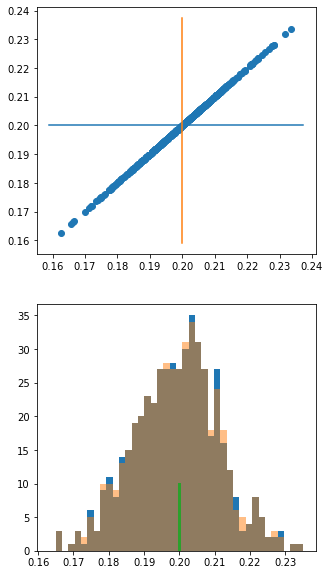

In [32]:
fig,ax = plt.subplots( 2, ndim, figsize=(5*ndim,5*2))

hbins=40
hmax = 10

for fi in range(ndim) :
    
    
    if ndim > 1 :
        thisax = ax[0][fi]
    else :
        thisax = ax[0]
        
    thisax.scatter( all_mean[fi,:n_for_plot], fit_results_mean_val[fi,:n_for_plot])
    xlow, xhigh = thisax.get_xlim()
    ylow, yhigh = thisax.get_ylim()
    print("  %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi, xlow, xhigh, ylow, yhigh))
    thisax.plot( (xlow, xhigh), (true_mu[fi], true_mu[fi]))
    thisax.plot( (true_mu[fi], true_mu[fi]), (ylow, yhigh))
    

    if ndim > 1 :
        thisax = ax[1][fi]
    else :
        thisax = ax[1]
    
    
    thisax.hist( fit_results_mean_val[fi,:n_for_plot], bins=hbins, 
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    thisax.hist( all_mean[fi,:n_for_plot], bins=hbins, alpha=0.5,
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    thisax.plot( (true_mu[fi],true_mu[fi]),(0,hmax), linewidth=3)
    

plt.show

In [33]:
if ndim > 1 :

    fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            ax[fi1][fi2].scatter( all_cov[fi1,fi2,:], fit_results_cov_val[fi1,fi2,:])
            xlow, xhigh = ax[fi1][fi2].get_xlim()
            ylow, yhigh = ax[fi1][fi2].get_ylim()
            print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
                  (fi1, fi2, xlow, xhigh, ylow, yhigh))
            ax[fi1][fi2].plot((xlow,xhigh),(true_cov[fi1][fi2], true_cov[fi1][fi2]))
            ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(ylow,yhigh))

    plt.show

In [34]:
if ndim > 1 :

    fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

    hbins=40
    hmax=10

    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            ax[fi1][fi2].hist( fit_results_cov_val[fi1,fi2,:], bins=hbins, 
                             range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
            ax[fi1][fi2].hist( all_cov[fi1,fi2,:], bins=hbins, alpha=0.5,
                             range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
            xlow, xhigh = ax[fi1][fi2].get_xlim()
            ylow, yhigh = ax[fi1][fi2].get_ylim()
            print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
                  (fi1, fi2, xlow, xhigh, ylow, yhigh))

            ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(0,hmax), linewidth=3)

    plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

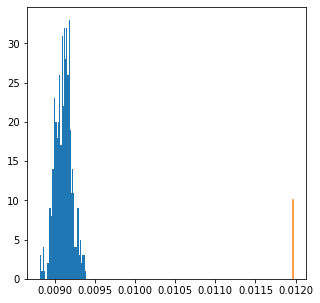

In [35]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins = 40
hmax = 10

for fi in range(ndim) :
    if ndim > 1 :
        thisax = ax[fi]
    else :
        thisax = ax
        
    thisax.hist( fit_results_mean_err[fi,:], bins=hbins )
    thisax.plot( (rms_mean[fi], rms_mean[fi]), (0,hmax) )
    
    
plt.show

In [36]:
fit_results_mean_err

array([[0.00914699, 0.00898545, 0.00923596, 0.00911935, 0.00893923,
        0.00910343, 0.00902018, 0.00901212, 0.00905156, 0.0090082 ,
        0.00914152, 0.00921593, 0.00911805, 0.00908669, 0.00904334,
        0.00881691, 0.00912909, 0.00901176, 0.00905612, 0.00898115,
        0.00893923, 0.00892315, 0.00917317, 0.00928955, 0.00911829,
        0.00909132, 0.00903988, 0.00911829, 0.00915557, 0.00918992,
        0.00880838, 0.00917554, 0.00922765, 0.00916526, 0.00929946,
        0.0091232 , 0.00899582, 0.00901419, 0.00922423, 0.00917606,
        0.00906867, 0.00910768, 0.00900133, 0.00905337, 0.00905747,
        0.00921563, 0.00927208, 0.00920698, 0.0090195 , 0.00912754,
        0.00913008, 0.00915588, 0.00899606, 0.00918444, 0.00910566,
        0.00904137, 0.00906083, 0.00911444, 0.00902237, 0.00902361,
        0.00911732, 0.00910542, 0.00926747, 0.00905037, 0.00920093,
        0.00925438, 0.00900657, 0.00911456, 0.00923557, 0.00884363,
        0.00900432, 0.0092319 , 0.00920029, 0.00

<function matplotlib.pyplot.show(close=None, block=None)>

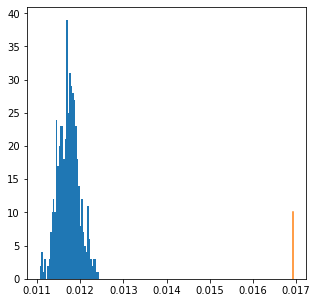

In [37]:
fig,ax = plt.subplots( 1, int((ndim*ndim+ndim)/2), figsize=(5*int((ndim*ndim+ndim)/2),5))

hbins = 40
hmax = 10

ai = 0

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        
        if ndim > 1 :
            thisax = ax[ai]
        else :
            thisax = ax

        thisax.hist( fit_results_cov_err[fi1,fi2,:], bins=hbins )
        thisax.plot( (rms_cov[fi1,fi2], rms_cov[fi1,fi2]), (0,hmax) )
        ai = ai + 1
    
plt.show

In [38]:
toy_fits_mu_rms = np.sqrt(np.var(fit_results_mean_val))
toy_fits_sig2_rms = np.sqrt(np.var(fit_results_cov_val))
toy_fits_mu_err_ave = np.average( fit_results_mean_err )
toy_fits_sig2_err_ave = np.average( fit_results_cov_err )

toy_fits_mu_ave = np.average( fit_results_mean_val )
toy_fits_sig2_ave = np.average( fit_results_cov_val )

print('\n\n')

print('  toy fits mu   ave. val  %7.4f,  true %7.4f' % (toy_fits_mu_ave, true_mu[0]))
print('  toy fits sig2 ave. val  %7.4f,  true %7.4f' % (toy_fits_sig2_ave, np.square(true_sig[0])))


print('\n\n')
print('  toy fits mu   RMS:  %7.4f,  ave fit err %7.4f' % (toy_fits_mu_rms, toy_fits_mu_err_ave))
print('  toy fits sig2 RMS:  %7.4f,  ave fit err %7.4f' % (toy_fits_sig2_rms, toy_fits_sig2_err_ave))
print('\n\n')




  toy fits mu   ave. val   0.1991,  true  0.2000
  toy fits sig2 ave. val   0.8294,  true  0.8100



  toy fits mu   RMS:   0.0120,  ave fit err  0.0091
  toy fits sig2 RMS:   0.0169,  ave fit err  0.0117





In [39]:


with open( '%s/fit-results.npy' % input_unfolding_dir, 'rb' ) as f :
    fit_results_mean_val = np.load(f, allow_pickle=True )
    fit_results_mean_err = np.load(f, allow_pickle=True )
    fit_results_cov_val = np.load(f, allow_pickle=True )
    fit_results_cov_err = np.load(f, allow_pickle=True )        


ave_fit_err_mean = np.zeros( ndim )

ave_fit_err_cov = np.zeros( shape=(ndim,ndim) )

for fi in range(ndim) :

    ave_fit_err_mean[fi] = np.mean( fit_results_mean_err[fi,:])

    print( '%d : ave fit error, mean :  %8.4f' % (fi, ave_fit_err_mean[fi]))

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :


        ave_fit_err_cov[fi1,fi2] = np.mean( fit_results_cov_err[fi1,fi2,:])

        print( 'fi1, fi2 : %d, %d    ave fit error, cov : %8.4f' % (fi1,fi2, ave_fit_err_cov[fi1,fi2]))


0 : ave fit error, mean :    0.0091
fi1, fi2 : 0, 0    ave fit error, cov :   0.0117


In [40]:
err_ratio = []

for fi in range(ndim) :
    err_ratio.append( rms_mean[fi] / ave_fit_err_mean[fi] )
    
for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        err_ratio.append( rms_cov[fi1,fi2]/ave_fit_err_cov[fi1,fi2] )

In [41]:
with open( '%s/parameter-uncertainty-results.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, rms_mean )
    np.save( f, rms_cov )
    np.save( f, ave_fit_err_mean )
    np.save( f, ave_fit_err_cov )
    np.save( f, err_ratio )

<function matplotlib.pyplot.show(close=None, block=None)>

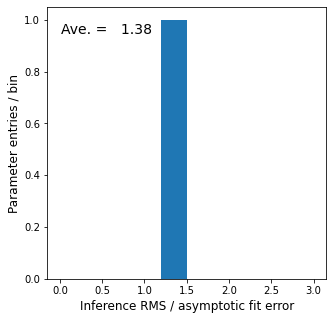

In [42]:
fig,ax = plt.subplots( 1, 1, figsize=(5,1*5))


plt.subplots_adjust( wspace=0.30, hspace=0.30)

ax.hist( err_ratio, bins=20, range=[0., 3.])

#ax.set_title( 'NN, poor resolution')
ax.set_xlabel( 'Inference RMS / asymptotic fit error', fontsize=12)
ax.set_ylabel( 'Parameter entries / bin', fontsize=12 )

ylim = ax.get_ylim()
xlim = ax.get_xlim()

tx = xlim[0] + 0.05 * (xlim[1] - xlim[0])
ty = ylim[0] + 0.90 * (ylim[1] - ylim[0])

ave_val = np.mean( err_ratio )

ax.text( tx, ty, 'Ave. = %6.2f' % ave_val, fontsize=14 )

plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

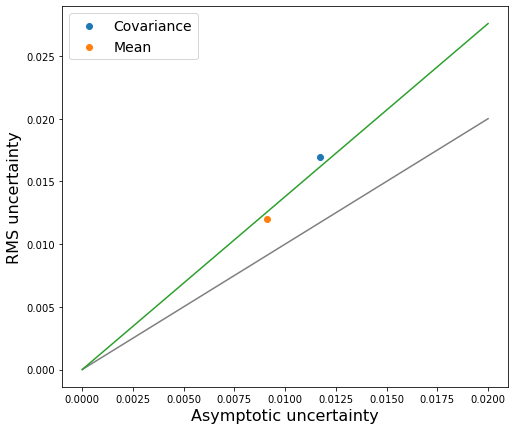

In [43]:
fig,ax = plt.subplots( 1, 1, figsize=(8*1,7*1))




axi = ax

axi.plot( [0,0.02], [0,0.02], color='tab:grey')
axi.plot( [0,0.02], [0,0.02*ave_val], color='tab:green')

axi.scatter( ave_fit_err_cov.flatten(), rms_cov.flatten(), color='tab:blue', label='Covariance' )
axi.scatter( ave_fit_err_mean, rms_mean, color='tab:orange', label='Mean' )



axi.set_xlabel( 'Asymptotic uncertainty', fontsize=16 )
axi.set_ylabel( 'RMS uncertainty', fontsize=16 )

axi.legend( fontsize=14 )


plt.show

In [44]:
def trunc_rms( vals, ratio_threshold=1.015, lverb=False ) :
    
    diffs = vals - np.mean( vals )
    
    rms0 = np.sqrt( np.cov(diffs) )
    if lverb : print('  RMS for all %d is %.5f' % (len(vals), rms0))
    
    dsub = diffs
    prevrms = rms0
    
    for i in range(6) :
        dmask = np.ones( len(dsub), dtype=bool )
        dmask[ np.argmax( np.abs(dsub)) ] = False
        removed_val = dsub[ np.argmax( np.abs(dsub)) ]
        dsub = dsub[dmask]
        subrms = np.sqrt( np.cov( dsub ))
        rmsratio = prevrms / subrms  
        if lverb :
            print( ' %3d  removed val %7.4f,  RMS old %.5f,  RMS new %.5f   ratio %.3f' % 
              (i, removed_val, prevrms, subrms, rmsratio ))
        if rmsratio < ratio_threshold :
            return prevrms

        prevrms = subrms
        
    return subrms
   

In [45]:
rms_mean_trunc = np.copy( rms_mean )
for i in range(ndim) :
    rms_mean_trunc[i] = trunc_rms( all_mean[i] )
    print('-- Mean %d' % i)
    print('  all RMS  %.5f,  trunc RMS  %.5f' % ( rms_mean[i], rms_mean_trunc[i] ) )


-- Mean 0
  all RMS  0.01197,  trunc RMS  0.01198


In [46]:
rms_cov_trunc = np.copy( rms_cov )
for i in range(ndim) :
    for j in range(i,ndim) :
        rms_cov_trunc[i,j] = trunc_rms( all_cov[i,j] )
        print('-- Cov %d, %d' % (i,j))
        print('  all RMS  %.5f,  trunc RMS  %.5f' % (rms_cov[i,j], rms_cov_trunc[i,j] ) )

-- Cov 0, 0
  all RMS  0.01694,  trunc RMS  0.01695


In [47]:
err_ratio_trunc = []

for fi in range(ndim) :
    err_ratio_trunc.append( rms_mean_trunc[fi] / ave_fit_err_mean[fi] )
    
for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        err_ratio_trunc.append( rms_cov_trunc[fi1,fi2]/ave_fit_err_cov[fi1,fi2] )

<function matplotlib.pyplot.show(close=None, block=None)>

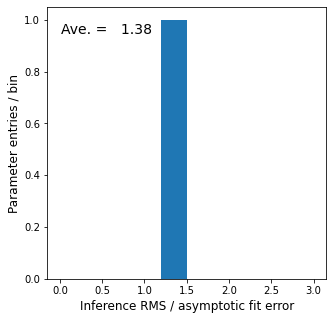

In [48]:
fig,ax = plt.subplots( 1, 1, figsize=(5,1*5))


plt.subplots_adjust( wspace=0.30, hspace=0.30)

ax.hist( err_ratio_trunc, bins=20, range=[0., 3.])

#ax.set_title( 'NN, poor resolution')
ax.set_xlabel( 'Inference RMS / asymptotic fit error', fontsize=12)
ax.set_ylabel( 'Parameter entries / bin', fontsize=12 )

ylim = ax.get_ylim()
xlim = ax.get_xlim()

tx = xlim[0] + 0.05 * (xlim[1] - xlim[0])
ty = ylim[0] + 0.90 * (ylim[1] - ylim[0])

ave_val_trunc = np.mean( err_ratio_trunc )

ax.text( tx, ty, 'Ave. = %6.2f' % ave_val_trunc, fontsize=14 )

plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

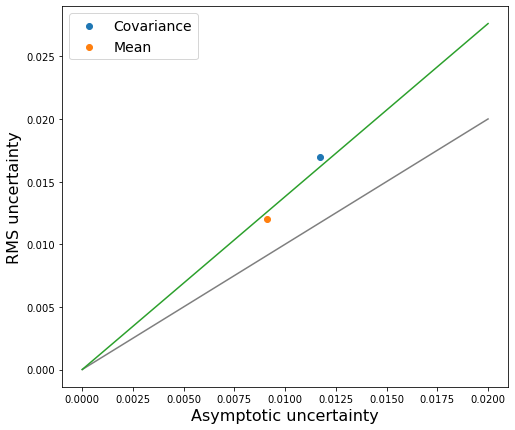

In [49]:
fig,ax = plt.subplots( 1, 1, figsize=(8*1,7*1))




axi = ax

axi.plot( [0,0.02], [0,0.02], color='tab:grey')
axi.plot( [0,0.02], [0,0.02*ave_val_trunc], color='tab:green')

axi.scatter( ave_fit_err_cov.flatten(), rms_cov_trunc.flatten(), color='tab:blue', label='Covariance' )
axi.scatter( ave_fit_err_mean, rms_mean_trunc, color='tab:orange', label='Mean' )



axi.set_xlabel( 'Asymptotic uncertainty', fontsize=16 )
axi.set_ylabel( 'RMS uncertainty', fontsize=16 )

axi.legend( fontsize=14 )


plt.show

In [50]:
with open( '%s/parameter-uncertainty-results-trunc.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, rms_mean_trunc )
    np.save( f, rms_cov_trunc )
    np.save( f, ave_fit_err_mean )
    np.save( f, ave_fit_err_cov )
    np.save( f, err_ratio_trunc )

## Calculate the event weight correlations

In [51]:

ncalc = 1000
npoints = 1000

max_count = ncalc
if npoints > ncalc : max_count = npoints


In [52]:
bootstrap_weights = np.zeros( shape = (n_samples, max_count) )

In [53]:
for fi in range(n_samples) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_unfolding_dir, fi)
    
    if exists(fname) :
        print( 'loading %s' % fname )
        with open(fname,'rb') as f :
            this_bootstrap_weights = np.load(f)
        bootstrap_weights[fi,:] = this_bootstrap_weights[0:max_count]
        
        
    else :
        print("\n\n *** file %s does not exist!\n\n" % fname )
        sys.exit()
        

loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-000.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-001.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-002.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-003.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-004.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-005.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-006.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-007.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-008.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-009.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-010.npy
loading output-run-kd

loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-249.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-250.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-251.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-252.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-253.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-254.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-255.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-256.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-257.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-258.npy
loading output-run-kde-study-1d-read-input-v0a-smearing-0.7500/bootstrap-weights-259.npy
loading output-run-kd

In [54]:

corr_array = np.zeros( ncalc )
print(" ncalc = %d" % ncalc)

point_index = 57

for i in range(ncalc) :
    pair_cor = np.corrcoef( np.row_stack( (bootstrap_weights[:,point_index], bootstrap_weights[:,i]) ))
    corr_array[i] = pair_cor[0,1]


 ncalc = 1000


<function matplotlib.pyplot.show(close=None, block=None)>

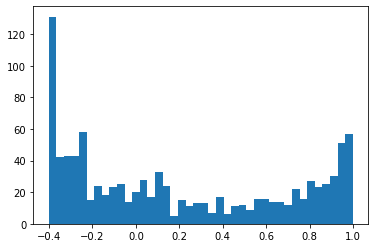

In [55]:
plt.hist( corr_array, bins=40)
plt.show

In [56]:
df0 = mc_pts[:,0] - mc_pts[point_index,0]

deltaf = mc_pts[:,:] - mc_pts[point_index,:]

dr2 = np.zeros( len(deltaf) )
for fi in range(0,ndim) :
    dr2 += deltaf[:,fi] * deltaf[:,fi]
dr = np.sqrt( dr2 )



<function matplotlib.pyplot.show(close=None, block=None)>

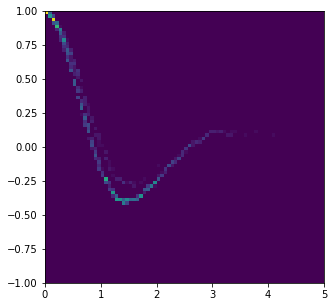

In [57]:
fig,ax = plt.subplots( 1, 1, figsize=(5,5))

ax.hist2d( dr[:ncalc], corr_array, bins=[80,80], range=([0,5],[-1,1]))
plt.show

In [58]:
%%time



for point_index in range(npoints) :
    
    if (point_index % (npoints/10) == 0 ) :
        print(" Working on point %3d" % point_index)
        
    this_point_corr_array = np.zeros(ncalc)
    
    for i in range(ncalc) :
        #if i == point_index : continue
        pair_cor = np.corrcoef( np.row_stack( (bootstrap_weights[:,point_index], bootstrap_weights[:,i]) ))
        this_point_corr_array[i] = pair_cor[0,1]
    
    if point_index == 0 :
        all_points_df0 = mc_pts[:ncalc,0] - mc_pts[point_index,0]

        all_points_deltaf = mc_pts[:ncalc,:] - mc_pts[point_index,:]
        dr2 = np.zeros( len(all_points_deltaf) )
        for fi in range(0,ndim) :
            dr2 += all_points_deltaf[:,fi] * all_points_deltaf[:,fi]
        all_points_dr = np.sqrt( dr2 )
        all_points_corr_array = this_point_corr_array
        all_points_f0b = mc_pts[:ncalc,0]

        all_points_coords = mc_pts[:ncalc,:]
    else :
        this_point_df0 = mc_pts[:ncalc,0] - mc_pts[point_index,0]

        this_point_deltaf = mc_pts[:ncalc,:] - mc_pts[point_index,:]
        dr2 = np.zeros( len(this_point_deltaf) )
        for fi in range(0,ndim) :
            dr2 += this_point_deltaf[:,fi] * this_point_deltaf[:,fi]
        all_points_dr = np.append( all_points_dr, np.sqrt( dr2 ) )       
        
        all_points_df0 = np.append( all_points_df0, this_point_df0 )

        all_points_corr_array = np.append(all_points_corr_array, this_point_corr_array)
        all_points_f0b = np.append(all_points_f0b, mc_pts[:ncalc,0] )

        all_points_coords = np.append( all_points_coords, mc_pts[:ncalc,:], axis=0 )


 Working on point   0
 Working on point 100
 Working on point 200
 Working on point 300
 Working on point 400
 Working on point 500
 Working on point 600
 Working on point 700
 Working on point 800
 Working on point 900
CPU times: user 50.9 s, sys: 6.27 s, total: 57.2 s
Wall time: 56.9 s


<function matplotlib.pyplot.show(close=None, block=None)>

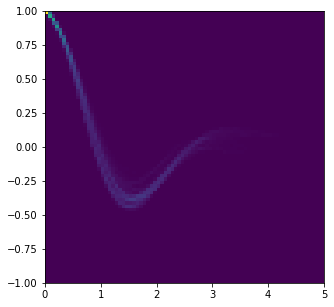

In [59]:
fig,ax = plt.subplots( 1, 1, figsize=(5,5))

hd = ax.hist2d( all_points_dr, all_points_corr_array, bins=[80,80], range=([0,5],[-1,1]))


plt.show

In [60]:
def profile2d_from_hdata( axis, hist_data,  drawline=True, hlabel="", mstyle='o' ) :
    
        
    nybins = len(hist_data[0][0])
    print("number of y bins: %d" % nybins)

    nxbins = len(hist_data[0])
    print("number of x bins: %d" % nxbins)



    x_vals = np.zeros( nxbins )
    avey_vals = np.zeros( nxbins )
    rmsy_vals = np.zeros( nxbins )

    for xbi in range( nxbins ) :

        wsum = 0
        ywsum = 0
        yywsum = 0

        xval = 0.5 * ( hist_data[1][xbi] + hist_data[1][xbi+1] )
        #print(" xbin %d has center at %6.3f" % ( xbin_ind, xval ))

        for ybi in range( nybins-1 ) :  # don't include the y-bin that corresponds to rho=1 (event with itself)
            yval = 0.5 * ( hist_data[2][ybi] + hist_data[2][ybi+1] )
            bin_content = hist_data[0][xbi][ybi]
            wsum = wsum + bin_content
            ywsum = ywsum + yval * bin_content
            yywsum = yywsum + yval * yval * bin_content
            #print("  %3d : y = %6.3f  bin content = %7d" % (bi, yval, bin_content))

        ave_y = ywsum / wsum
        ave_yy = yywsum / wsum
        rms_y = ave_yy - ave_y * ave_y
        #print(" Ave y = %.3f, RMS y = %.3f" % ( ave_y, rms_y) )

        x_vals[xbi] = xval
        avey_vals[xbi] = ave_y
        rmsy_vals[xbi] = rms_y


    #for xbi in range( nxbins ) :
        #print("  %4d :  x = %7.3f   ave y = %7.3f  rms y = %7.3f" % ( xbi, x_vals[xbi], avey_vals[xbi], rmsy_vals[xbi]))

    if drawline :
        axis.plot( (hist_data[1][0], hist_data[1][-1]), (0,0) )  
    
    axis.errorbar( x_vals, avey_vals, yerr=rmsy_vals, marker='%s' % mstyle, label=hlabel)
    

    
    plt.show
    


number of y bins: 80
number of x bins: 80


<function matplotlib.pyplot.show(close=None, block=None)>

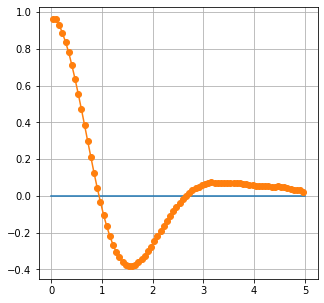

In [61]:
fig,ax = plt.subplots( 1, 1, figsize=(5,5))

profile2d_from_hdata( ax, hd )

ax.grid(True)

plt.show

In [62]:
with open( '%s/correlations.npy' % input_unfolding_dir, 'wb') as f :
    np.save(f, all_points_df0)
    np.save(f, all_points_dr)
    np.save(f, all_points_corr_array)

with open( '%s/correlation-points-feature-coords.npy' % input_unfolding_dir, 'wb') as f :
    np.save(f, all_points_f0b)
    np.save(f, all_points_coords)
    

In [63]:
if ndim > 1 :
    print('\n\n\n Skipping the rest, which is only for 1d.\n\n')
    sys.exit()

## Do the binned chi2 fits

In [64]:

if use_uniform_fit_hist_binning :
    
    fitting_hist_bins = np.linspace( uniform_fit_hist_xlow, uniform_fit_hist_xhigh, uniform_fit_hist_nbins+1 )
    fitting_hist_bin_widths = fitting_hist_bins[1:] - fitting_hist_bins[0:-1]
    fitting_hist_bin_centers = 0.5 * ( fitting_hist_bins[1:] + fitting_hist_bins[0:-1] )
    fitting_hist_n_bins = uniform_fit_hist_nbins
    
    print('\n\n Using uniform fit hist binning:  %.4f to %.4f in %d bins' % (
    uniform_fit_hist_xlow, uniform_fit_hist_xhigh, uniform_fit_hist_nbins))
    
    print('\n\n fitting_hist_bins calculated : %s\n\n' % str(fitting_hist_bins))
    
else :

    binning_file = '%s/binning.npy' % sample_input_dir

    with open(binning_file,'rb') as f :
        fitting_hist_bins = np.load(f)
        fitting_hist_bin_widths = np.load(f)
        fitting_hist_bin_centers = np.load(f)
        fitting_hist_n_bins = np.load(f)

    print('\n\n fitting_hist_bins read from file : %s\n\n' % str(fitting_hist_bins))
    
print(' fitting_hist_n_bins  %d' % fitting_hist_n_bins )




 Using uniform fit hist binning:  -3.0000 to 4.0000 in 15 bins


 fitting_hist_bins calculated : [-3.         -2.53333333 -2.06666667 -1.6        -1.13333333 -0.66666667
 -0.2         0.26666667  0.73333333  1.2         1.66666667  2.13333333
  2.6         3.06666667  3.53333333  4.        ]


 fitting_hist_n_bins  15


 boot   0 weights: [0.09511925 0.11798256 0.06524012 ... 0.0801359  0.08986147 0.12491232]
 boot   1 weights: [0.10095929 0.1170865  0.06063099 ... 0.0826898  0.0952877  0.11875615]
 boot   2 weights: [0.09290129 0.11836267 0.0637324  ... 0.07760789 0.08829237 0.12364354]
 boot   3 weights: [0.09574411 0.11894918 0.05951333 ... 0.07759221 0.09020814 0.12163893]
 boot   4 weights: [0.0978264  0.12270471 0.05969402 ... 0.07590784 0.09009947 0.12022748]
 boot   5 weights: [0.09273049 0.11952738 0.06041414 ... 0.07553571 0.08594539 0.11844339]
 boot   6 weights: [0.09638658 0.12170722 0.05772337 ... 0.07538905 0.08949485 0.12448046]
 boot   7 weights: [0.09537842 0.12144441 0.05622147 ... 0.07489768 0.08815489 0.1259127 ]
 boot   8 weights: [0.0947423  0.12002146 0.05739082 ... 0.07559573 0.08831607 0.12322918]
 boot   9 weights: [0.09899199 0.12124951 0.06155959 ... 0.07927813 0.09197332 0.12234593]
 boot  10 weights: [0.0925422  0.12038715 0.0584147  ... 0.07656491 0.08657318 0.12624996]

 boot  93 weights: [0.09482698 0.12181545 0.05736817 ... 0.0748415  0.08808272 0.1199922 ]
 boot  94 weights: [0.09492968 0.11959207 0.05383638 ... 0.07350676 0.08770736 0.12154715]
 boot  95 weights: [0.09918945 0.1150862  0.05770327 ... 0.07862689 0.09308196 0.12707229]
 boot  96 weights: [0.09284701 0.11975381 0.05836174 ... 0.07462793 0.08754777 0.12372564]
 boot  97 weights: [0.09412851 0.12151263 0.05825577 ... 0.07406631 0.08739961 0.12506833]
 boot  98 weights: [0.09802541 0.11751306 0.05680401 ... 0.07525771 0.09078149 0.12288812]
 boot  99 weights: [0.09340087 0.12171462 0.06101235 ... 0.07390369 0.08674195 0.12714954]
 boot 100 weights: [0.09382005 0.11758301 0.05644351 ... 0.07312663 0.08670576 0.12021581]
 boot 101 weights: [0.09580734 0.12258582 0.05387215 ... 0.07294059 0.08800658 0.12658851]
 boot 102 weights: [0.09426752 0.11943236 0.05902591 ... 0.07627874 0.08903537 0.12331839]
 boot 103 weights: [0.09191387 0.12114391 0.05730623 ... 0.07240137 0.08499852 0.12977409]

 boot 184 weights: [0.09464789 0.12055268 0.05680671 ... 0.07492233 0.08868738 0.12358158]
 boot 185 weights: [0.09562765 0.11831492 0.05916899 ... 0.07692758 0.08901613 0.12323167]
 boot 186 weights: [0.09853235 0.121963   0.05671117 ... 0.07706675 0.09053715 0.11884837]
 boot 187 weights: [0.09856262 0.11971855 0.06206812 ... 0.08050764 0.09256575 0.12164937]
 boot 188 weights: [0.09370944 0.12360379 0.05531879 ... 0.07316731 0.08651186 0.12793454]
 boot 189 weights: [0.09755293 0.11525711 0.0604942  ... 0.07917534 0.09156465 0.11888865]
 boot 190 weights: [0.09497932 0.1204922  0.05730285 ... 0.0758284  0.08948086 0.12293618]
 boot 191 weights: [0.09287085 0.12056172 0.05713364 ... 0.07214787 0.08698456 0.12110485]
 boot 192 weights: [0.09571562 0.11826666 0.05900817 ... 0.07716329 0.08908006 0.12373293]
 boot 193 weights: [0.09428739 0.11541001 0.06078398 ... 0.07824254 0.08971437 0.12007615]
 boot 194 weights: [0.09370064 0.11928388 0.0604779  ... 0.07447045 0.08711499 0.12263023]

 boot 276 weights: [0.09729287 0.12232837 0.06206892 ... 0.07841721 0.09053807 0.12450403]
 boot 277 weights: [0.09399795 0.11739658 0.0608597  ... 0.07911024 0.0897816  0.11750159]
 boot 278 weights: [0.09409487 0.11794481 0.06182982 ... 0.07848183 0.08844574 0.12097625]
 boot 279 weights: [0.09653854 0.11893297 0.05636647 ... 0.07649391 0.08977434 0.12005185]
 boot 280 weights: [0.09350967 0.11715965 0.0617839  ... 0.0763342  0.08703066 0.12060819]
 boot 281 weights: [0.09749598 0.1158162  0.06219178 ... 0.0794843  0.09137888 0.11588384]
 boot 282 weights: [0.09675418 0.11851543 0.05668777 ... 0.07644363 0.09049814 0.11542564]
 boot 283 weights: [0.09681017 0.12081934 0.05623939 ... 0.07986682 0.09118038 0.12078044]
 boot 284 weights: [0.094181   0.1205638  0.05895827 ... 0.07573855 0.08765938 0.12684226]
 boot 285 weights: [0.09255063 0.11666309 0.05383757 ... 0.07152549 0.08529559 0.12221415]
 boot 286 weights: [0.09579846 0.12011211 0.05735531 ... 0.07698369 0.08949778 0.12511148]

 boot 374 weights: [0.09746162 0.11802708 0.0586025  ... 0.07617325 0.09052213 0.11685662]
 boot 375 weights: [0.09448621 0.11873236 0.05594954 ... 0.07250899 0.08730592 0.11955068]
 boot 376 weights: [0.09444324 0.11939368 0.06531669 ... 0.07922086 0.08919484 0.12591979]
 boot 377 weights: [0.09499289 0.11998495 0.06066732 ... 0.07813338 0.08843682 0.1239325 ]
 boot 378 weights: [0.09281002 0.12096234 0.05985254 ... 0.07711819 0.08805867 0.12475125]
 boot 379 weights: [0.09820682 0.11715343 0.05906757 ... 0.07672353 0.09229351 0.12094988]
 boot 380 weights: [0.09565031 0.12026557 0.06657121 ... 0.0799749  0.09007465 0.12366319]
 boot 381 weights: [0.09403056 0.12313792 0.05780789 ... 0.07444261 0.08746538 0.12451364]
 boot 382 weights: [0.09560039 0.11646872 0.06206729 ... 0.08192779 0.09168151 0.12467153]
 boot 383 weights: [0.09164693 0.11849167 0.06295012 ... 0.07644714 0.0871305  0.12434488]
 boot 384 weights: [0.09501746 0.1181765  0.06461101 ... 0.07846911 0.08977506 0.12560175]

 boot 465 weights: [0.09781901 0.11733973 0.06105948 ... 0.07789532 0.0910958  0.11684976]
 boot 466 weights: [0.093739   0.11913597 0.05515132 ... 0.07591694 0.08766281 0.11983616]
 boot 467 weights: [0.09249916 0.12175822 0.05682524 ... 0.07501576 0.08683824 0.12582413]
 boot 468 weights: [0.09639629 0.12291197 0.05701449 ... 0.07359606 0.0888677  0.11821976]
 boot 469 weights: [0.0950996  0.11667116 0.06077884 ... 0.07595062 0.08872984 0.12639887]
 boot 470 weights: [0.09320759 0.11911433 0.05272594 ... 0.07278064 0.08595477 0.11989106]
 boot 471 weights: [0.09653273 0.11514435 0.05985122 ... 0.07848066 0.09120119 0.11985587]
 boot 472 weights: [0.09468331 0.11816793 0.05913391 ... 0.07697465 0.08806456 0.12553334]
 boot 473 weights: [0.09609877 0.11721265 0.05840335 ... 0.07691434 0.090419   0.1236328 ]
 boot 474 weights: [0.09631231 0.12001858 0.06202412 ... 0.07938944 0.08994475 0.12451634]
 boot 475 weights: [0.09350792 0.11761217 0.05854103 ... 0.07415539 0.08694558 0.11984164]

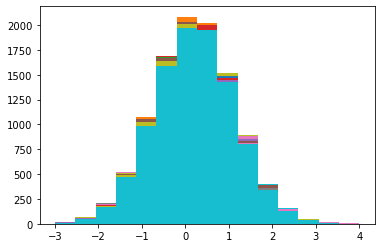

In [65]:
boot_hist_content = np.zeros( shape=(n_samples, fitting_hist_n_bins ))


simple_calc_mean = np.zeros( n_samples )
simple_calc_cov  = np.zeros( n_samples )

of_weight_sum = np.zeros( n_samples )


for bi in range(n_samples) :

    if samples_from_GenerateInput :
        
        rd = read_sample( sample_input_dir, bi )

        ngen_true = rd['ngen_true']
        ngen_mc = rd['ngen_mc']


        true_det_pts = rd['true_det_pts']
        mc_pts = rd['mc_pts']
        mc_det_pts = rd['mc_det_pts']
    
    
            
    fname = '%s/bootstrap-weights-%03d.npy' % (input_unfolding_dir, bi)

    if not exists(fname) :  
        print('\n\n *** Missing %s' % fname )
        continue

    with open(fname,'rb') as f :            

        final_push_weights_scaled = np.load(f)
        print(' boot %3d weights: ' % bi, end='')
        print( final_push_weights_scaled)

        of_weight_sum[bi] = np.sum( final_push_weights_scaled )

        hist_content,_,_ = plt.hist( mc_pts[:,0], bins=fitting_hist_bins, weights=final_push_weights_scaled )
        #print(hist_content)
        boot_hist_content[bi,:] = hist_content


        mean_cov = calc_mean_cov( final_push_weights_scaled, 0, 0 )

        simple_calc_mean[bi] = mean_cov['mean_x1']
        simple_calc_cov[bi]  = mean_cov['cov_x1x2']
        
        
        

<function matplotlib.pyplot.show(close=None, block=None)>

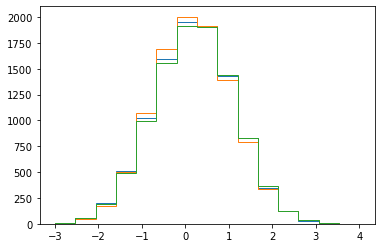

In [66]:
plt.stairs( boot_hist_content[0,:], edges=fitting_hist_bins )
plt.stairs( boot_hist_content[1,:], edges=fitting_hist_bins )
plt.stairs( boot_hist_content[2,:], edges=fitting_hist_bins )
plt.show

In [67]:
with open( '%s/binned-output-histograms.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, boot_hist_content )


In [68]:
hist_nbins = fitting_hist_n_bins


hist_corr_mat = np.zeros( shape=(hist_nbins, hist_nbins) )
hist_cov_mat = np.zeros( shape=(hist_nbins, hist_nbins) )

for bi in range(hist_nbins) :
    
    for bj in range( hist_nbins ) :
        
        ccm = np.corrcoef( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        cvm =      np.cov( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        
        hist_corr_mat[bi,bj] = ccm[0,1]
        
        hist_cov_mat[bi,bj] = cvm[0,1]
        
        if bi == bj : hist_cov_mat[bi,bj] = hist_cov_mat[bi,bj] + diagonal_constant
        

In [69]:
hist_corr_mat[0,hist_nbins-1] = -1.

In [70]:
min_cov_element = np.min(hist_cov_mat)
max_cov_element = np.max(hist_cov_mat)
print('\n\n Min and max elements of cov mat:  %.2f , %.2f\n\n' % (min_cov_element, max_cov_element))
hist_cov_mat_copy = np.copy( hist_cov_mat )
hist_cov_mat_copy[0,hist_nbins-1] = -1. * max_cov_element



 Min and max elements of cov mat:  -423.46 , 1242.13




<function matplotlib.pyplot.show(close=None, block=None)>

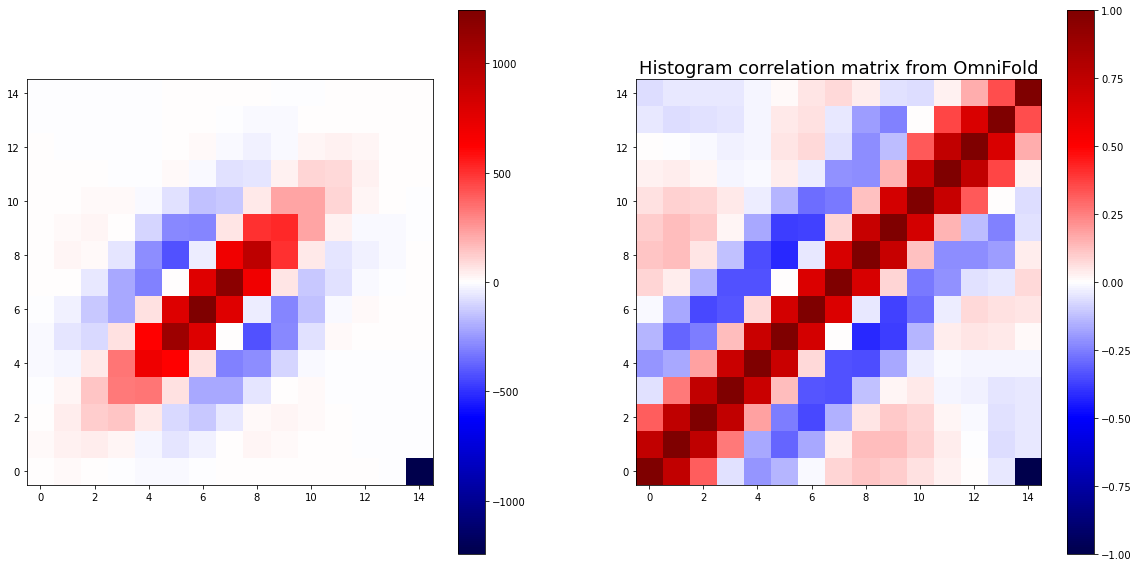

In [71]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_corr_mat, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )



ax[1].set_title('Histogram correlation matrix from OmniFold', fontsize=18)



plt.show

In [72]:
with open( '%s/binned-cov-and-cor-mats.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, hist_cov_mat_copy )
    np.save( f, hist_corr_mat )

In [73]:
hist_cov_inv = np.linalg.inv( hist_cov_mat )
cov_inv_test = np.matmul( hist_cov_mat, hist_cov_inv )

In [74]:
hist_cov_mat_diagonal = np.copy( hist_cov_mat )
for bi in range(hist_nbins) :
    for bj in range(hist_nbins) :
        if bi != bj : hist_cov_mat_diagonal[bi,bj] = 0.

In [75]:
hist_cov_inv_diagonal = np.linalg.inv( hist_cov_mat_diagonal )

In [76]:
ci_min = np.min(hist_cov_inv)
ci_max = np.max(hist_cov_inv)
print('\n\n min and max of covariance matrix inverse:  %.2f  %.2f\n\n' % (ci_min, ci_max))

hist_cov_inv_copy = np.copy( hist_cov_inv )
hist_cov_inv_copy[0,hist_nbins-1] = -1. * ci_max



 min and max of covariance matrix inverse:  -0.14  0.49




<function matplotlib.pyplot.show(close=None, block=None)>

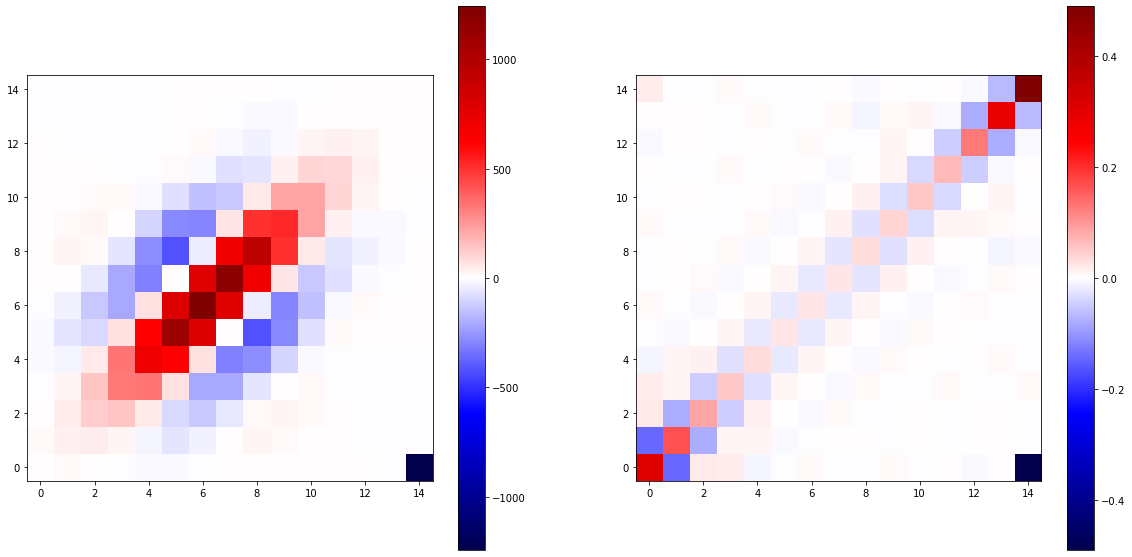

In [77]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_inv_copy, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

In [78]:

hist_cov_pinv = np.linalg.pinv( hist_cov_mat, rcond_val )


In [79]:
hist_cov_pinv_minus_inv = hist_cov_pinv - hist_cov_inv
cov_pinv_test = np.matmul( hist_cov_mat, hist_cov_pinv )

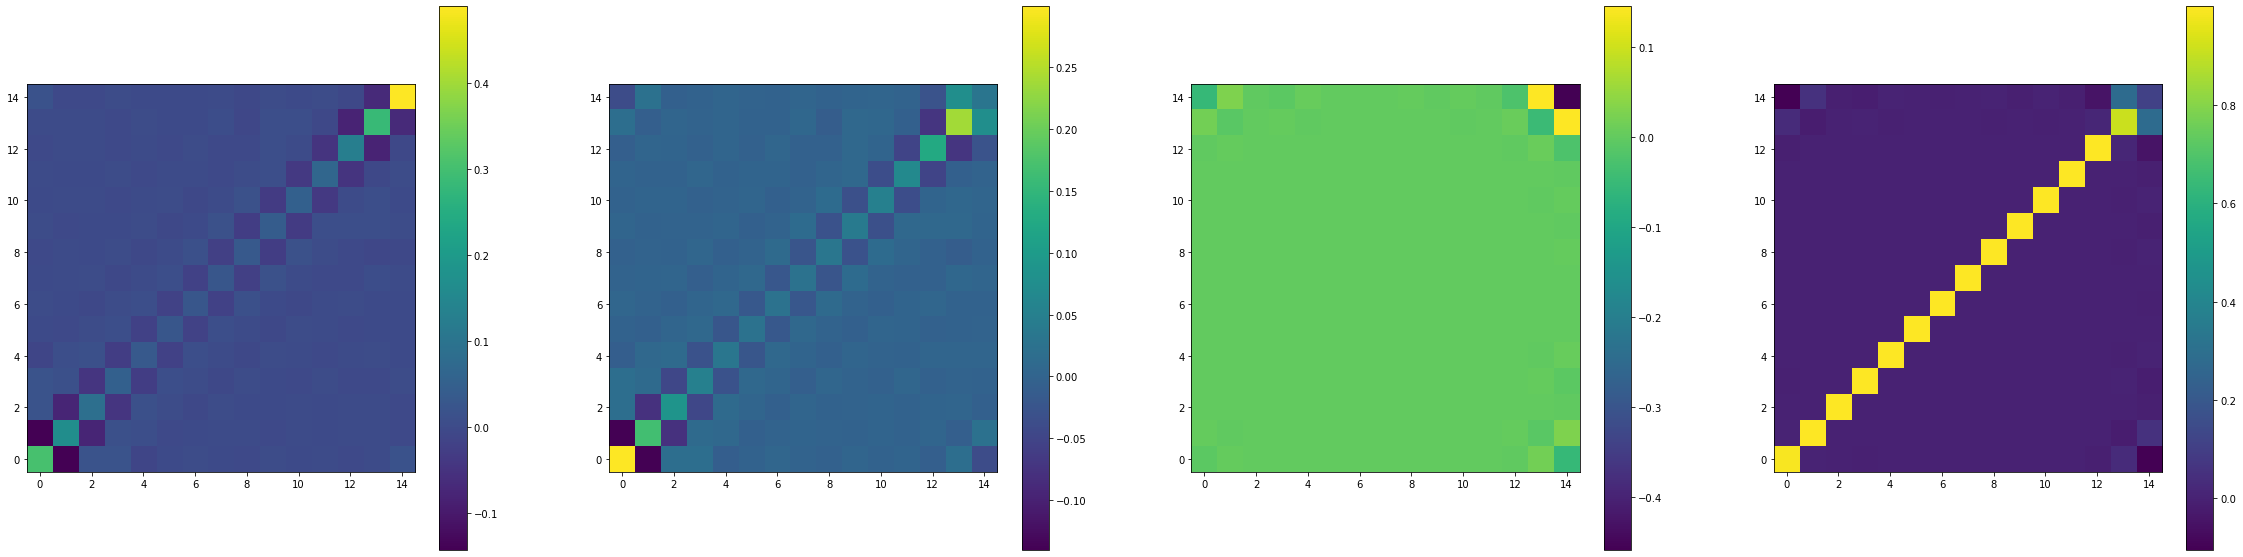

In [80]:
fig,ax = plt.subplots( 1, 4, figsize=(4*10,10))



im_covinv = ax[0].imshow(hist_cov_inv, origin='lower')
ax[0].figure.colorbar( im_covinv, ax=ax[0] )

im_covpinv = ax[1].imshow(hist_cov_pinv, origin='lower')
ax[1].figure.colorbar( im_covpinv, ax=ax[1] )

im_covpinvdiff = ax[2].imshow(hist_cov_pinv_minus_inv, origin='lower')
ax[2].figure.colorbar( im_covpinvdiff, ax=ax[2] )

im_pinv_test = ax[3].imshow(cov_pinv_test, origin='lower')
ax[3].figure.colorbar( im_pinv_test, ax=ax[3] )



In [81]:
cpi_min = np.min(hist_cov_pinv)
cpi_max = np.max(hist_cov_pinv)
print('\n\n min and max of covariance matrix pseudo inverse:  %.2f  %.2f\n\n' % (cpi_min, cpi_max))

hist_cov_pinv_copy = np.copy( hist_cov_pinv )
hist_cov_pinv_copy[0,hist_nbins-1] = -1. * cpi_max




 min and max of covariance matrix pseudo inverse:  -0.14  0.30




<function matplotlib.pyplot.show(close=None, block=None)>

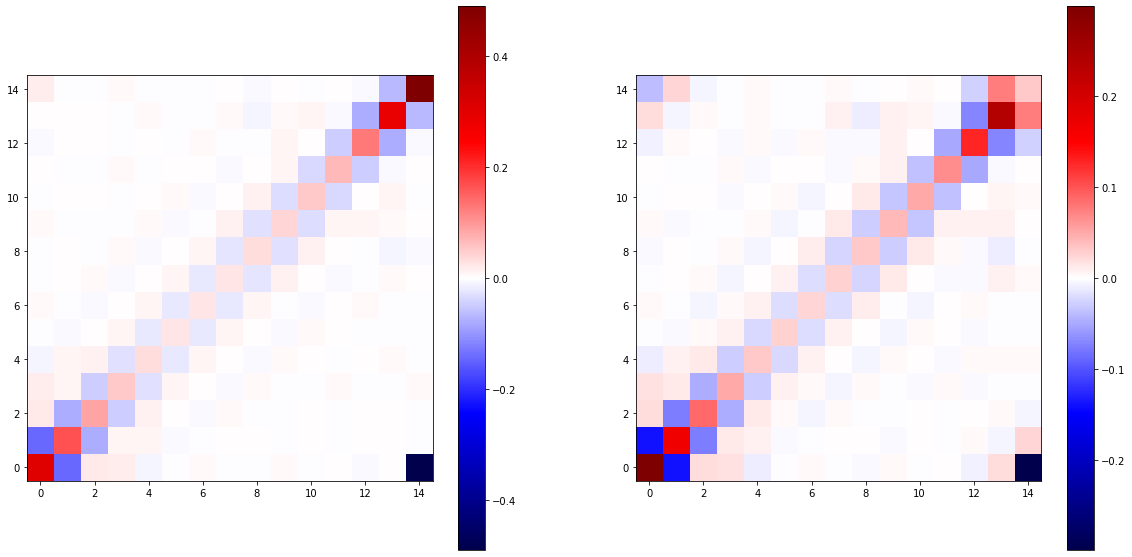

In [82]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_inv_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_pinv_copy, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

## Set up a Minuit fit

Used this example from Glen Cowan as a starting point: https://github.com/KMISchool2022/histFit/blob/main/histFit.ipynb


In [83]:
import iminuit
from iminuit import Minuit
import scipy.stats as stats
from scipy.stats import chi2

from scipy import special


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [84]:


def f_bin_center_approx(x, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    
    model_norm =  1. / ( np.sqrt( 2 * 3.14159265 * sigma2 ) )
    
    model_pred = model_norm * np.exp( -0.5 * np.square((x - mu))/sigma2 )
    
    return theta * model_pred



def f_integral_within_bin(x_low, x_high, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    sigma = np.sqrt(sigma2)
    
    model_pred = 0.5 * ( 1. + special.erf( (x_high - mu )/(sigma*np.sqrt(2.)) ) ) - 0.5 * ( 1. + special.erf( (x_low - mu )/(sigma*np.sqrt(2.)) ) )
    
    return theta * model_pred



class ChiSquared:                   # function to be minimized

    def __init__(self, xHist, bin_edges, covMatInv, fitType, verbose=0):
        self.setData(xHist, bin_edges, covMatInv, verbose)
        self.fitType = fitType
        
    def setData(self, xHist, bin_edges, covMatInv, verbose):
        numVal = np.sum(xHist)
        numBins = len(xHist)
        binLowEdge = np.zeros(numBins)
        binHighEdge = np.zeros(numBins)
        for bi in range(numBins) :
            binLowEdge[bi] = bin_edges[bi]
            binHighEdge[bi] = bin_edges[bi+1]
        binWidth = binHighEdge - binLowEdge
        binCenter = 0.5 * (binLowEdge + binHighEdge)
            
        self.data = xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv

        if verbose > 0 :
            print('\n\n setData:')
            print('  numVal: %12.1f  numBins = %d' % (numVal, numBins))
            print('  binLowEdge: ', end='' )
            print('  fitType: %s' % fitType )
            print( binLowEdge)


        
    def chi2LS_integral_within_bin(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_integral_within_bin(binLowEdge, binHighEdge, par)
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


    def chi2LS_bin_center_approx(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_bin_center_approx(binCenter, par) * binWidth
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


        
    def __call__(self, par):
        if fitType == 'integral within bin' :
            return self.chi2LS_integral_within_bin(par)
        elif fitType == 'bin center approximation' :
            return self.chi2LS_bin_center_approx(par)
        else :
            print('\n\n *** Unknown fitType :  %s\n\n' % fitType )
            return -1

        
        

In [85]:

chi2_fit_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_sig2_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_sig2_err = np.zeros( len(boot_hist_content) )



for si in range( len(boot_hist_content) ) :
    
    # Initialize Minuit and set up fit:
    theta = 1
    mu = 0.2
    sigma2 = 0.81
    #fitType = 'full cov'

    parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
    parname = ['theta', 'mu', 'sigma2']
    parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
    parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
    parfix  = [False, False, False]            # change to fix/free param.
    parlim  = [(0.5, 1.5), (None, None), (0., None)]

    chisq = ChiSquared( boot_hist_content[si], fitting_hist_bins, hist_cov_pinv, fitType)
    chisq_diag = ChiSquared( boot_hist_content[si], fitting_hist_bins, hist_cov_inv_diagonal, fitType)


    m = Minuit(chisq, parin, name=parname)
    m.errors = parstep
    m.fixed = parfix
    m.limits = parlim
    m.errordef = 1.0                      # errors from chi2 = chi2min + 1


    m_diag = Minuit(chisq_diag, parin, name=parname)
    m_diag.errors = parstep
    m_diag.fixed = parfix
    m_diag.limits = parlim
    m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1    
    
    
    # do the fit, get errors, extract results
    m.migrad()                                        # minimize -logL
    parhat = m.values                                 # max-likelihood estimates
    sigma_parhat = m.errors                           # standard deviations
    cov = m.covariance                                # covariance matrix
    rho = m.covariance.correlation()                  # correlation coeffs.

    m_diag.migrad()                                        # minimize -logL
    parhat_diag = m_diag.values                                 # max-likelihood estimates
    sigma_parhat_diag = m_diag.errors                           # standard deviations
    cov_diag = m_diag.covariance                                # covariance matrix
    rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.

    
    chi2_fit_mu_val[si] = parhat[1]
    chi2_fit_mu_err[si] = sigma_parhat[1]

    chi2_fit_sig2_val[si] = parhat[2]
    chi2_fit_sig2_err[si] = sigma_parhat[2]

    
    chi2_fit_diag_mu_val[si] = parhat_diag[1]
    chi2_fit_diag_mu_err[si] = sigma_parhat_diag[1]

    chi2_fit_diag_sig2_val[si] = parhat_diag[2]
    chi2_fit_diag_sig2_err[si] = sigma_parhat_diag[2]

    
    

    
    
    
    print(' %3d : mu %8.4f +/- %8.4f  (%8.4f +/- %8.4f)    sig2 %8.4f +/- %8.4f  (%8.4f +/- %8.4f)' %
          (si, 
           parhat[1], sigma_parhat[1],
           parhat_diag[1], sigma_parhat_diag[1],
           parhat[2], sigma_parhat[2],
           parhat_diag[2], sigma_parhat_diag[2],
          )
         )
    

   0 : mu   0.1834 +/-   0.0117  (  0.1807 +/-   0.0075)    sig2   0.8476 +/-   0.0167  (  0.8422 +/-   0.0099)
   1 : mu   0.1814 +/-   0.0117  (  0.1722 +/-   0.0075)    sig2   0.8228 +/-   0.0167  (  0.8143 +/-   0.0098)
   2 : mu   0.1969 +/-   0.0119  (  0.1935 +/-   0.0076)    sig2   0.8483 +/-   0.0168  (  0.8489 +/-   0.0100)
   3 : mu   0.1993 +/-   0.0118  (  0.1948 +/-   0.0075)    sig2   0.8327 +/-   0.0171  (  0.8267 +/-   0.0100)
   4 : mu   0.1976 +/-   0.0117  (  0.1948 +/-   0.0074)    sig2   0.8118 +/-   0.0172  (  0.8061 +/-   0.0100)
   5 : mu   0.1954 +/-   0.0120  (  0.1946 +/-   0.0076)    sig2   0.8193 +/-   0.0173  (  0.8151 +/-   0.0102)
   6 : mu   0.2168 +/-   0.0117  (  0.2114 +/-   0.0074)    sig2   0.8256 +/-   0.0168  (  0.8218 +/-   0.0099)
   7 : mu   0.2094 +/-   0.0118  (  0.2077 +/-   0.0075)    sig2   0.8192 +/-   0.0172  (  0.8140 +/-   0.0100)
   8 : mu   0.2095 +/-   0.0119  (  0.2064 +/-   0.0075)    sig2   0.8161 +/-   0.0170  (  0.8124 +/-   

 104 : mu   0.2122 +/-   0.0119  (  0.2070 +/-   0.0075)    sig2   0.8136 +/-   0.0170  (  0.8059 +/-   0.0100)
 105 : mu   0.2037 +/-   0.0117  (  0.1985 +/-   0.0074)    sig2   0.8380 +/-   0.0164  (  0.8348 +/-   0.0098)
 106 : mu   0.2144 +/-   0.0117  (  0.2109 +/-   0.0074)    sig2   0.8298 +/-   0.0171  (  0.8219 +/-   0.0100)
 107 : mu   0.2026 +/-   0.0118  (  0.1989 +/-   0.0075)    sig2   0.8428 +/-   0.0166  (  0.8419 +/-   0.0099)
 108 : mu   0.1850 +/-   0.0119  (  0.1829 +/-   0.0075)    sig2   0.8070 +/-   0.0171  (  0.8015 +/-   0.0099)
 109 : mu   0.2029 +/-   0.0119  (  0.2002 +/-   0.0076)    sig2   0.8400 +/-   0.0166  (  0.8371 +/-   0.0099)
 110 : mu   0.1919 +/-   0.0118  (  0.1910 +/-   0.0075)    sig2   0.8382 +/-   0.0172  (  0.8356 +/-   0.0102)
 111 : mu   0.2073 +/-   0.0117  (  0.2029 +/-   0.0074)    sig2   0.8127 +/-   0.0169  (  0.8080 +/-   0.0099)
 112 : mu   0.2124 +/-   0.0121  (  0.2084 +/-   0.0076)    sig2   0.8006 +/-   0.0171  (  0.7970 +/-   

 183 : mu   0.2024 +/-   0.0118  (  0.1983 +/-   0.0075)    sig2   0.8120 +/-   0.0171  (  0.8059 +/-   0.0100)
 184 : mu   0.2180 +/-   0.0119  (  0.2134 +/-   0.0075)    sig2   0.8303 +/-   0.0174  (  0.8224 +/-   0.0101)
 185 : mu   0.2128 +/-   0.0119  (  0.2097 +/-   0.0075)    sig2   0.8356 +/-   0.0170  (  0.8328 +/-   0.0101)
 186 : mu   0.1963 +/-   0.0117  (  0.1918 +/-   0.0074)    sig2   0.8013 +/-   0.0169  (  0.7917 +/-   0.0099)
 187 : mu   0.1880 +/-   0.0117  (  0.1830 +/-   0.0074)    sig2   0.8273 +/-   0.0168  (  0.8203 +/-   0.0099)
 188 : mu   0.2208 +/-   0.0118  (  0.2200 +/-   0.0075)    sig2   0.8063 +/-   0.0168  (  0.8013 +/-   0.0099)
 189 : mu   0.1804 +/-   0.0119  (  0.1780 +/-   0.0076)    sig2   0.8457 +/-   0.0175  (  0.8362 +/-   0.0102)
 190 : mu   0.2089 +/-   0.0118  (  0.2069 +/-   0.0075)    sig2   0.8352 +/-   0.0174  (  0.8272 +/-   0.0101)
 191 : mu   0.2069 +/-   0.0120  (  0.2072 +/-   0.0076)    sig2   0.8274 +/-   0.0178  (  0.8224 +/-   

 269 : mu   0.2007 +/-   0.0120  (  0.1957 +/-   0.0076)    sig2   0.8493 +/-   0.0169  (  0.8477 +/-   0.0101)
 270 : mu   0.1875 +/-   0.0118  (  0.1859 +/-   0.0075)    sig2   0.8352 +/-   0.0175  (  0.8252 +/-   0.0102)
 271 : mu   0.2159 +/-   0.0119  (  0.2114 +/-   0.0076)    sig2   0.8238 +/-   0.0175  (  0.8169 +/-   0.0103)
 272 : mu   0.1921 +/-   0.0120  (  0.1883 +/-   0.0076)    sig2   0.8177 +/-   0.0172  (  0.8119 +/-   0.0101)
 273 : mu   0.1960 +/-   0.0118  (  0.1906 +/-   0.0075)    sig2   0.8256 +/-   0.0163  (  0.8226 +/-   0.0097)
 274 : mu   0.2118 +/-   0.0118  (  0.2123 +/-   0.0075)    sig2   0.8434 +/-   0.0170  (  0.8423 +/-   0.0100)
 275 : mu   0.2123 +/-   0.0119  (  0.2103 +/-   0.0075)    sig2   0.8250 +/-   0.0168  (  0.8224 +/-   0.0100)
 276 : mu   0.1879 +/-   0.0117  (  0.1853 +/-   0.0074)    sig2   0.8207 +/-   0.0167  (  0.8144 +/-   0.0098)
 277 : mu   0.1776 +/-   0.0121  (  0.1749 +/-   0.0077)    sig2   0.8296 +/-   0.0177  (  0.8204 +/-   

 372 : mu   0.2149 +/-   0.0121  (  0.2128 +/-   0.0077)    sig2   0.8315 +/-   0.0175  (  0.8263 +/-   0.0102)
 373 : mu   0.1966 +/-   0.0118  (  0.1917 +/-   0.0075)    sig2   0.8354 +/-   0.0167  (  0.8283 +/-   0.0098)
 374 : mu   0.1848 +/-   0.0118  (  0.1834 +/-   0.0075)    sig2   0.8412 +/-   0.0176  (  0.8360 +/-   0.0102)
 375 : mu   0.2095 +/-   0.0119  (  0.2082 +/-   0.0076)    sig2   0.8373 +/-   0.0177  (  0.8313 +/-   0.0103)
 376 : mu   0.1965 +/-   0.0117  (  0.1910 +/-   0.0075)    sig2   0.8665 +/-   0.0169  (  0.8572 +/-   0.0100)
 377 : mu   0.2091 +/-   0.0117  (  0.2062 +/-   0.0075)    sig2   0.8667 +/-   0.0173  (  0.8556 +/-   0.0101)
 378 : mu   0.2063 +/-   0.0119  (  0.2048 +/-   0.0075)    sig2   0.8324 +/-   0.0170  (  0.8268 +/-   0.0100)
 379 : mu   0.2022 +/-   0.0118  (  0.1967 +/-   0.0075)    sig2   0.8271 +/-   0.0169  (  0.8212 +/-   0.0100)
 380 : mu   0.1925 +/-   0.0117  (  0.1890 +/-   0.0074)    sig2   0.8606 +/-   0.0167  (  0.8561 +/-   

 475 : mu   0.2041 +/-   0.0120  (  0.2018 +/-   0.0076)    sig2   0.8551 +/-   0.0176  (  0.8503 +/-   0.0104)
 476 : mu   0.2214 +/-   0.0118  (  0.2175 +/-   0.0075)    sig2   0.8681 +/-   0.0168  (  0.8637 +/-   0.0100)
 477 : mu   0.1899 +/-   0.0119  (  0.1835 +/-   0.0075)    sig2   0.8035 +/-   0.0170  (  0.7949 +/-   0.0100)
 478 : mu   0.1894 +/-   0.0118  (  0.1870 +/-   0.0075)    sig2   0.8071 +/-   0.0167  (  0.8037 +/-   0.0098)
 479 : mu   0.1984 +/-   0.0120  (  0.1929 +/-   0.0077)    sig2   0.8327 +/-   0.0168  (  0.8297 +/-   0.0100)
 480 : mu   0.2111 +/-   0.0116  (  0.2066 +/-   0.0074)    sig2   0.8186 +/-   0.0165  (  0.8150 +/-   0.0098)
 481 : mu   0.1814 +/-   0.0117  (  0.1833 +/-   0.0074)    sig2   0.8001 +/-   0.0176  (  0.7924 +/-   0.0101)
 482 : mu   0.2130 +/-   0.0121  (  0.2093 +/-   0.0077)    sig2   0.8188 +/-   0.0175  (  0.8158 +/-   0.0103)
 483 : mu   0.1986 +/-   0.0118  (  0.1945 +/-   0.0075)    sig2   0.8523 +/-   0.0167  (  0.8460 +/-   

<function matplotlib.pyplot.show(close=None, block=None)>

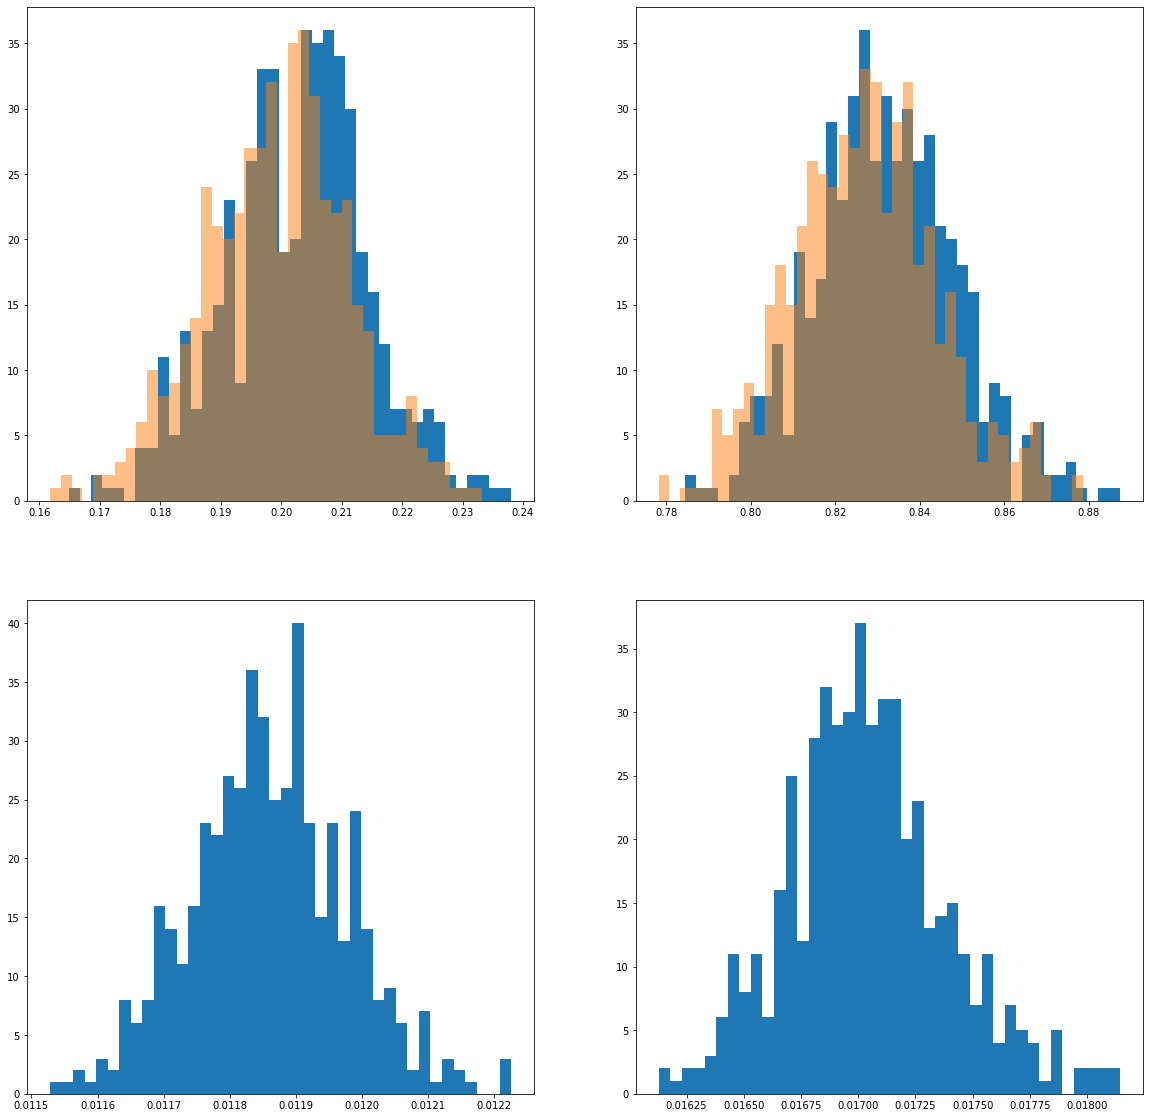

In [86]:
fig,ax = plt.subplots( 2, 2, figsize=(2*10,2*10))

ax[0][0].hist( chi2_fit_mu_val, bins=40 )
ax[0][0].hist( chi2_fit_diag_mu_val, bins=40, alpha=0.5 )

ax[0][1].hist( chi2_fit_sig2_val, bins=40 )
ax[0][1].hist( chi2_fit_diag_sig2_val, bins=40, alpha=0.5 )


ax[1][0].hist( chi2_fit_mu_err, bins=40 )

ax[1][1].hist( chi2_fit_sig2_err, bins=40 )


plt.show

In [87]:


mean_mu = np.mean( chi2_fit_mu_val )
mean_mu2 = np.mean( chi2_fit_mu_val * chi2_fit_mu_val )
rms_mu = np.sqrt( mean_mu2 - mean_mu * mean_mu )

mean_sig2 = np.mean( chi2_fit_sig2_val )
mean_sig22 = np.mean( chi2_fit_sig2_val * chi2_fit_sig2_val )
rms_sig2 = np.sqrt( mean_sig22 - mean_sig2 * mean_sig2 )

mean_mu_fit_err = np.mean( chi2_fit_mu_err )
mean_sig2_fit_err = np.mean( chi2_fit_sig2_err )





mean_mu_diag = np.mean( chi2_fit_diag_mu_val )
mean_mu2_diag = np.mean( chi2_fit_diag_mu_val * chi2_fit_diag_mu_val )
rms_mu_diag = np.sqrt( mean_mu2_diag - mean_mu_diag * mean_mu_diag )

mean_sig2_diag = np.mean( chi2_fit_diag_sig2_val )
mean_sig22_diag = np.mean( chi2_fit_diag_sig2_val * chi2_fit_diag_sig2_val )
rms_sig2_diag = np.sqrt( mean_sig22_diag - mean_sig2_diag * mean_sig2_diag )

mean_mu_fit_err_diag = np.mean( chi2_fit_diag_mu_err )
mean_sig2_fit_err_diag = np.mean( chi2_fit_diag_sig2_err )




print('\n\n')
print(' mean: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_mu, rms_mu, mean_mu_fit_err,    mean_mu_diag, rms_mu_diag, mean_mu_fit_err_diag))
print(' sig2: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_sig2, rms_sig2, mean_sig2_fit_err,   mean_sig2_diag, rms_sig2_diag, mean_sig2_fit_err_diag))
print('\n\n')





 mean:  0.2027, rms  0.0118, mean fit err  0.0119  |  diag. chi2 fit    0.1991, rms  0.0120, mean fit err  0.0075
 sig2:  0.8321, rms  0.0170, mean fit err  0.0170  |  diag. chi2 fit    0.8269, rms  0.0171, mean fit err  0.0100





In [88]:
with open( '%s/chi2-fit-results.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, chi2_fit_mu_val )
    np.save( f, chi2_fit_sig2_val )
    np.save( f, chi2_fit_mu_err )
    np.save( f, chi2_fit_sig2_err )
    np.save( f, chi2_fit_diag_mu_val )
    np.save( f, chi2_fit_diag_sig2_val )
    np.save( f, chi2_fit_diag_mu_err )
    np.save( f, chi2_fit_diag_sig2_err )
    
    
    
    

In [89]:
print('\n\n Done \n\n')



 Done 


